<a href="https://colab.research.google.com/github/Kenz2000/Supervised-learning-project/blob/main/final__Last_version_2_supervised_learning(Partie2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Partie 2: Données relationnelles
Dans cette partie, nous examinons les données relationnelles, qui comprennent deux
types d’informations : une matrice de valeurs objet-caractéristiques et un graphe des liens entre les objets. Ces deux aspects fournissent des informations utiles sous divers angles, mais ils ne sont pas toujours cohérents et nécessitent donc un alignement attentif
pour obtenir les meilleurs résultats de classification.

L’objectif de cette phase du projet est de traiter ce problème, en mettant en lumière les différents défis posés par ce type de données pour les méthodes de classification supervisé

**Instalation des packages necessaires**

In [ ]:
!pip install scikit-plot

**Importation des libraries**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import neighbors
from imblearn.over_sampling import SMOTE
import scipy.io as io
import networkx as nx
import scipy.io as sio
import os.path
import scipy.sparse as sp
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import warnings
from google.colab import drive
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
datasets_name=["cora"]

**Analyse descriptive**

L’ensemble de données que nous avons traités représentent deux types d’informations : une matrice des valeurs objet-caractéristiques X et un graphe des liens entre objets (matrice d’adjacence A).

**Choix du Dataset :**
Dans notre étude nous avons choisi l’ensemble de données Cora, Il est constitué d’articles sur l’apprentissage automatique. Ces articles sont classés dans l’une des sept catégories suivantes : Case Based, Genetic Algorithms, Neural Networks, Probabilistic Methods, Rule Learning ,Reinforcement Learning, Theory.


**Chargement du dataset Cora**

Cette fonction permet de charger le fichier cora.mat et rcupérer les données suivantes :

*   Matrice d'attribut X : c'est une matrice papers_words
*   Matrice d'adjancence A : c'est une matrice carrée papers_papers qui est un graphe des liens de citations entre eux.
*   true_row_labels : les classes des papers de la matrice X




In [ ]:
def load_data(data):
  data=data+'.mat'
  matlab_dict = io.loadmat(data)
  #Adjacency matrix
  A = matlab_dict['W']
  #Features matrix
  X = matlab_dict['fea']
  true_row_labels = matlab_dict['gnd'].flatten()
  return A,X ,true_row_labels

In [ ]:
A,X,true_row_labels=load_data('cora')

Chaque article du datset Cora cite ou soit cité par au moins un autre article. L’ensemble du corpus compte 2708 articles, le vocabulaire se compose de 1 433 mots uniques. Les mots ayant une fréquence inférieure à 10 ont été éliminés.

In [ ]:
def informations_Matrix_graph(dataset_name):
    data = sio.loadmat(os.path.join( f'{dataset_name}.mat'))
    features = data['fea'].astype(float)
    adj = data['W']
    adj = adj.astype(float)
    if not sp.issparse(adj):
        adj = sp.csc_matrix(adj)
    if sp.issparse(features):
        features = features.toarray()
    labels = data['gnd'].reshape(-1) - 1
    n_classes = len(np.unique(labels))
    # Print some statistics about the dataset
    print("Number of papers:", features.shape[0])
    print("Number of features per paper:", features.shape[1])
    print("Number of classes:", np.unique(labels).shape[0])
    print("Number of edges in the citation network:", int(adj.sum()/2))


Cette fonction renvoie diverses informations du jeu de données Cora, notamment le nombre de documents, le nombre de mots dans le vocabulaire, le nombre de classes, ainsi que le nombre d'arêtes qui constituent le graphe.

In [ ]:
informations_Matrix_graph('cora')

Number of papers: 2708
Number of features per paper: 1433
Number of classes: 7
Number of edges in the citation network: 5278


**Réprésentation de la matrcie de corrélation de X et A**

In [ ]:
def heatmap(A,X,show_X,show_A):
  if show_X==True:
    X_df = pd.DataFrame(X)
    sns.heatmap(X_df.corr())
  if show_A==True:
    A_df = pd.DataFrame(A)
    sns.heatmap(A_df.corr())

Les corrélations entre les mots (termes) de la matrice d'attributs X

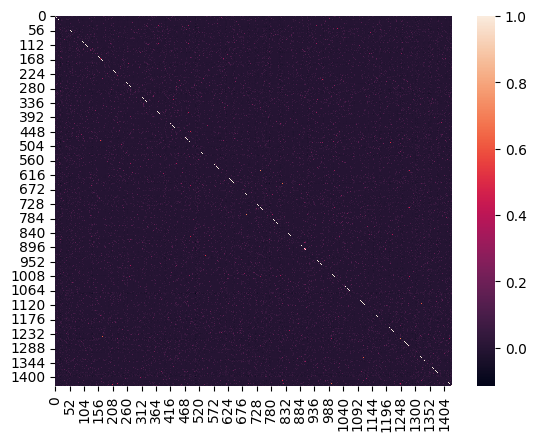

In [ ]:
heatmap(A,X,True,False)

Corrélation entre les papers de la matrice d'ajacence A

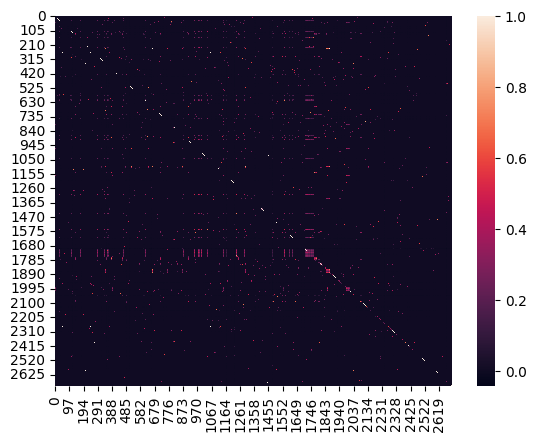

In [ ]:
heatmap(A,X,False,True)

En analysant ces deux représentations, nous observons qu’il n’y a aucune relation linéaire entre les mots de la matrice des articles X. En revanche, pour la matrice d’adjacence A, nous constatons qu’il y a quelques articles qui sont positivement corrélés les uns
aux autres.

**Visualisation du graphe et degré de distribution de ses nœuds**

En exploitant la matrice des objets X et la matrice d’adjacence A, nous avons élaboré le graphe des données Cora, en tenant compte du degré de distribution de ses
nœuds.

In [ ]:
def build_graph(A,X,true_row_labels,dataset_name):

  edges=[]
  for i in range(0,A.shape[0]):
    for j in range (0,A.shape[0]):
        if A[i][j]==1:
          if [i,j] or [j,i] not in edges:
            edges.append([i,j])
  #for i , j in zip(edges.index,)
  # Extract the node labels and features
  node_labels = true_row_labels
  node_features = X.astype(np.float32)

  # Create a NetworkX graph
  graph = nx.Graph()

  # Add nodes to the graph with features and labels
  for i in range(len(node_labels)):
      graph.add_node(i, label=node_labels[i], features=node_features[i])

  # Add edges to the graph
  for edge in edges:
      graph.add_edge(edge[0], edge[1])

  # Visualize the graph
  fig, ax = plt.subplots(figsize=(6, 6))
  pos = nx.spring_layout(graph)
  nx.draw_networkx_nodes(graph, pos, node_size=20, cmap="cool", alpha=0.8)
  nx.draw_networkx_edges(graph, pos, alpha=0.2)
  ax.set_title(f"{dataset_name} dataset graph visualization")
  plt.show()

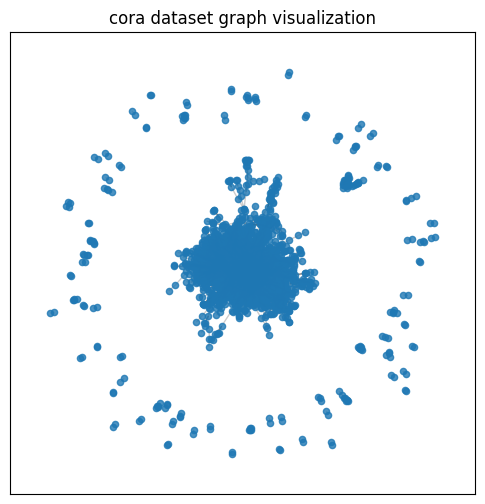

In [ ]:
build_graph(A,X,true_row_labels,dataset_name='cora')

**Le degré de distribution des noeuds du Graphe G du Cora**

In [ ]:
def degre_distribution(A,X,dataset_name):
  #import matplotlib.pyplot as plt

  edges=[]
  for i in range(0,A.shape[0]):
    for j in range (0,A.shape[0]):
        if A[i][j]!=0:
            edges.append([i,j])

  # Create a NetworkX graph
  graph = nx.Graph()

  # Add edges to the graph
  for edge in edges:
      graph.add_edge(edge[0], edge[1])

  # Compute the degree distribution
  degrees = [graph.degree(node) for node in graph.nodes()]
  degree_counts = np.bincount(degrees)

  # Plot the degree distribution
  fig, ax = plt.subplots()
  ax.bar(np.arange(len(degree_counts)), degree_counts)
  ax.set_xlabel('Degree')
  ax.set_ylabel('Number of nodes')
  ax.set_title(f'{dataset_name} dataset degree distribution')
  plt.show()


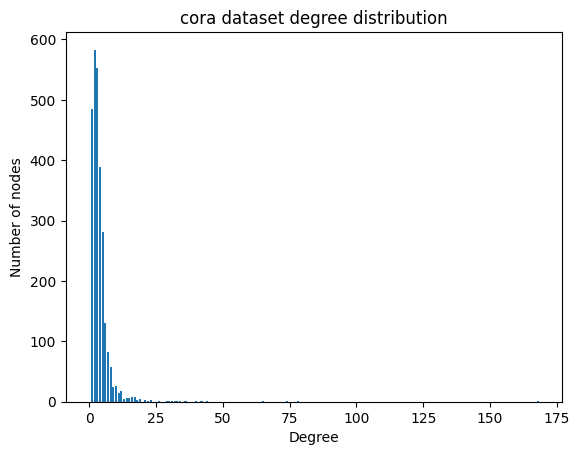

In [ ]:
degre_distribution(A,X,'cora')

Fusionner la colonne classe(label) avec la matrice X




In [ ]:
X_df = pd.DataFrame(X)
Y_df=pd.DataFrame(true_row_labels)

In [ ]:
X_df['label']=Y_df

In [ ]:
X_df.columns = X_df.columns.astype(str)

**Vérification de l'existance des valeurs null**

In [ ]:
X_df.isnull().sum()

0        0
1        0
2        0
3        0
4        0
        ..
1429     0
1430     0
1431     0
1432     0
label    0
Length: 1434, dtype: int64

**Vérification de l'existence des valeurs manquantes**

In [ ]:
X_df.isna().sum()

0        0
1        0
2        0
3        0
4        0
        ..
1429     0
1430     0
1431     0
1432     0
label    0
Length: 1434, dtype: int64

**Visualisation des pourcentages des classes de la matrice X**

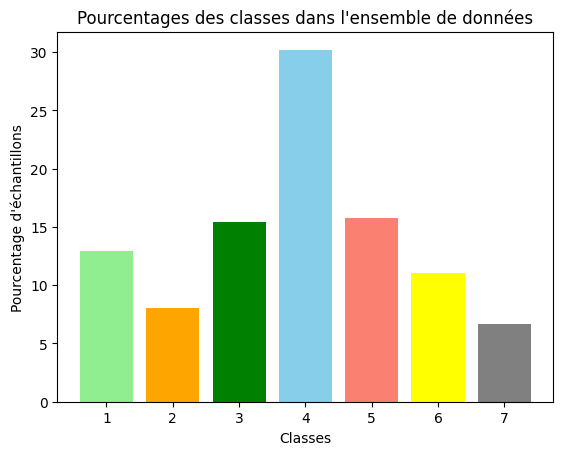

In [ ]:
# Calculer les pourcentages des classes
class_counts = Counter(X_df['label'])
total_samples = len(X_df['label'])
class_percentages = {cls: count/total_samples * 100 for cls, count in class_counts.items()}

# Visualiser les pourcentages des classes à l'aide d'un diagramme à barres
colors = ['skyblue', 'salmon', 'lightgreen','green','orange','yellow','gray']
plt.bar(class_percentages.keys(), class_percentages.values(), color=colors)
plt.title("Pourcentages des classes dans l'ensemble de données")
plt.xlabel('Classes')
plt.ylabel('Pourcentage d\'échantillons')
plt.show()

Sur la figure ci-dessus, nous examinons le pourcentage des 7 classes dans l’ensemble de données Cora. Nous remarquons qu’il y a un léger déséquilibre entre les classes, nécessitant ainsi un rééquilibrage pour améliorer les performances des modèles de classification supervisé.

#Application des modèles de classification

Dans cette partie, nous avons appliqué divers algorithmes d’apprentissage supervisé, tels que le KNN, les SVM linéaires et non linéaires, le LDA, le QDA, la régression logistique, Random Forest, XGBoost et le naïf bayésien. Ces algorithmes ont été utilisés sur la matrice X d’origine, X rééquilibrée en terme des classes, et la combinaison de X avec A(matrice d’adjacence) en utilisant différentes fonctions d’agrégation.

**Matrice d’attribut (features) X**

**Partitionnement de l'ensemble de données**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_df,Y_df,test_size=0.3,random_state = 123, stratify =Y_df)

**Méthodes pour identifier la valeur optimale de k dans l'algorithme KNN**

Pour déterminer la valeur appropriée de K, nous avons employé deux approches : la validation croisée et le Gridsearch.

Méthode de cross validation

In [ ]:
def find_k_Cross_validation(X_train,Y_train):
  k_values = range(1, 25)
  best_k = 0
  best_accuracy = 0
  accuracy_scores=[]
  for k in k_values:
      # Initialiser le classificateur k-NN
      knn = KNeighborsClassifier(n_neighbors=k)
      # Utiliser la validation croisée pour évaluer la performance pour chaque k
      scores = cross_val_score(knn, X_train, Y_train, cv=5)
      accuracy = scores.mean()
      accuracy_scores.append(accuracy)

      # Mettre à jour la meilleure valeur de k si une meilleure précision est trouvée
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          best_k = k

  # plot
  plt.plot(range(1, 25),accuracy_scores)
  plt.xlabel('valeurs de K')
  plt.ylabel('accuracy')
  plt.title('Méthode de cross validation')
  plt.show()
  print("Le meilleur K est:",best_k)

Méthode de GridSearch

In [ ]:
def find_k_Grid_search(X_train,Y_train):
  param_grid = {'n_neighbors': np.arange(1, 21)}

  # Créer le modèle k-NN
  knn = KNeighborsClassifier()

  # Utiliser la validation croisée en grille pour trouver la meilleure valeur de k
  grid_search = GridSearchCV(knn, param_grid, cv=5)
  grid_search.fit(X_train, Y_train)
  return grid_search.best_params_['n_neighbors']

Avec GridSearch

In [ ]:
best_k=find_k_Grid_search(X_train,Y_train)

Avec Cross Validation

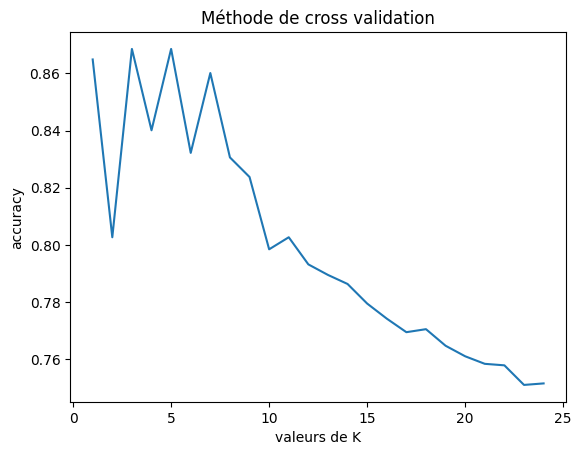

Le meilleur K est: 5


In [ ]:
find_k_Cross_validation(X_train,Y_train)

Les deux méthodes ont déterminé la bonne valeur de K qui est de 5

**Création des fonction d'évaluation (Accuracy, NMI, F1-score, AUC) des méthodes de classification**

In [ ]:
#true_row_labels[:813]
def metrics_evaluation(y_test,y_pred,y_score):
  y_test_nmi = y_test.astype(np.int).values
  y_test_nmi=y_test_nmi.flatten()

  acc=metrics.accuracy_score(y_test, y_pred)
  nmi = normalized_mutual_info_score(y_test_nmi, y_pred)
  f1_score=metrics.f1_score(Y_test, y_pred,average='macro')
  y_test_bin = label_binarize(Y_test, classes=np.unique(Y_test))
  AUC = metrics.roc_auc_score(y_test_bin,y_score,multi_class='ovr')
  return (acc,nmi,f1_score,AUC)


def comput_fpr_tpr(method,Y_test,y_scores):
  y_test_bin = label_binarize(Y_test, classes=np.unique(Y_test))
  fpr_avg, tpr_avg, _ = metrics.roc_curve(y_test_bin.ravel(), y_scores.ravel())
  return fpr_avg,tpr_avg

**Fonction pour générer la courbe ROC des modèles**

In [ ]:
def Plot_all_ROC(Roc):
  for name in  Roc.keys():
    # Plotter moyenne de la courbe ROC
    plt.plot(Roc[name][0],  Roc[name][1], label=f'ROC curve ={name}', linestyle='--', linewidth=2)


  plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model', alpha=0.5)

  plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect model', color="green")
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve for All models Multiclass Classification')
  plt.legend()
  plt.show()

**Application des modèles de classification sur la matrice X**

À présent, nous mettons en œuvre divers modèles d'apprentissage supervisé sur la matrice X et comparons leurs performances en utilisant différentes métriques d'évaluation.

In [ ]:
methods = {}
methods['Logistic Regression'] = {'model': LogisticRegression(), 'results': {}}
methods['KNN'] = {'model': KNeighborsClassifier(n_neighbors=best_k), 'results': {}}
methods['CART'] = {'model': DecisionTreeClassifier(criterion='gini',
                                 random_state=42,
                                 min_samples_split=2,
                                 ), 'results': {}}
methods['XGB'] = {'model':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 min_samples_split=2,random_state=0)
, 'results': {}}
methods['Naive_Bayes'] = {'model':GaussianNB(), 'results': {}}
methods['LDA'] = {'model':LinearDiscriminantAnalysis(), 'results': {}}
methods['QDA'] = {'model': QuadraticDiscriminantAnalysis(), 'results': {}}
methods['Lineair SVM'] = {'model':OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())), 'results': {}}
methods['Non Lineair SVM'] = {'model': OneVsRestClassifier(CalibratedClassifierCV(SVC())), 'results': {}}
methods['Random Forest'] = {'model': RandomForestClassifier(criterion='gini',
                                 n_estimators=10,
                                 random_state=1,
                                 min_samples_split=2,
                                 n_jobs=2), 'results': {}}

Cette fonction a pour objectif de former tous les modèles de classification sur les données d'entraînement de X, puis de les évaluer sur les données de test en utilisant des métriques telles que l'accuracy, l'indice de similarité normalisé (NMI), le score F1, l'Aire sous la courbe (AUC),  la matrice de confusion ainsi que la courbe ROC.

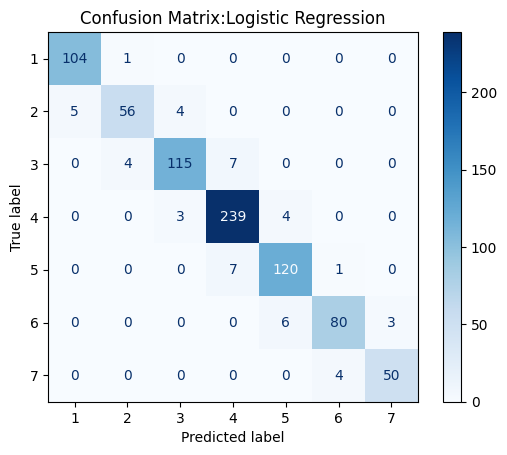

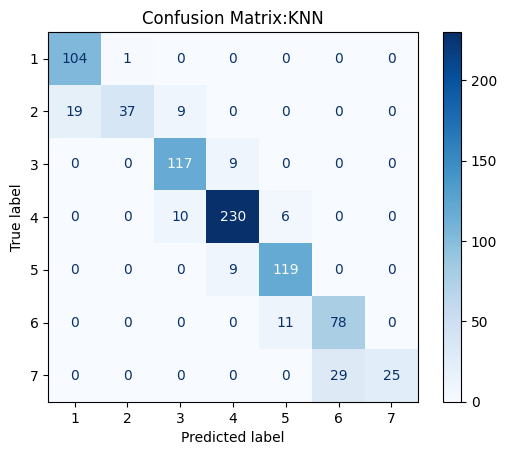

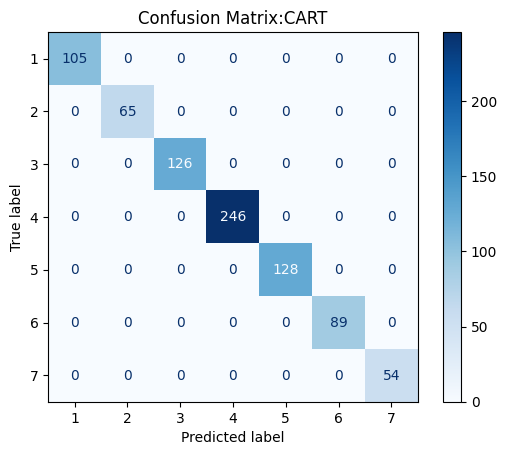

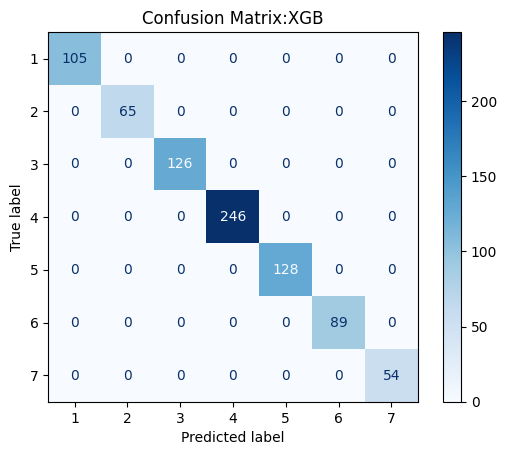

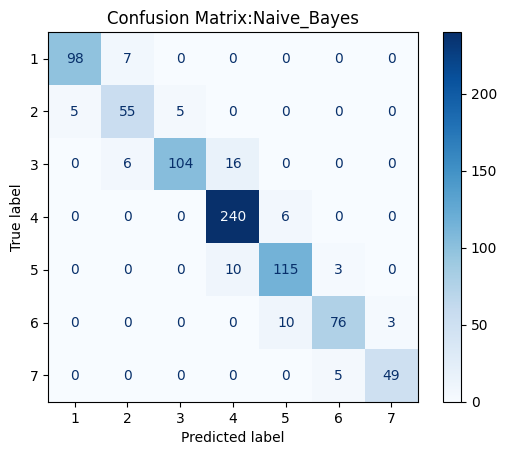

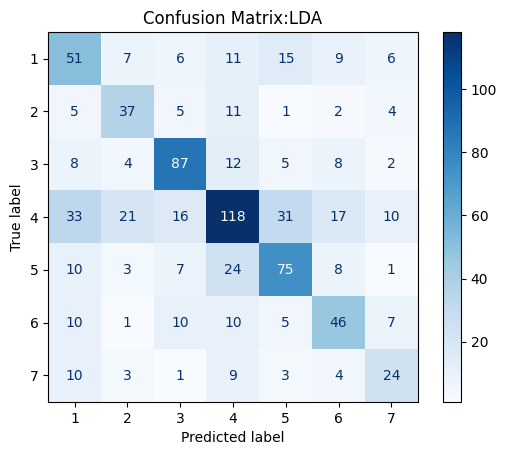

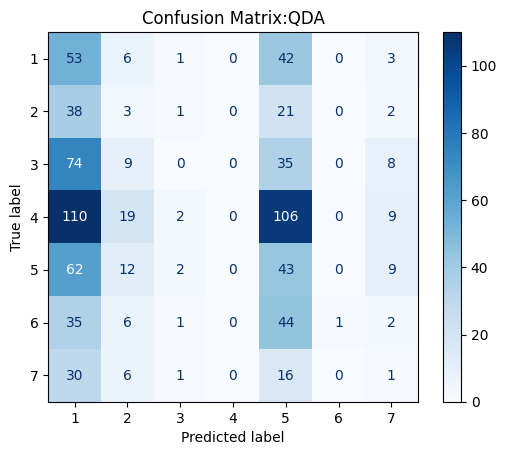

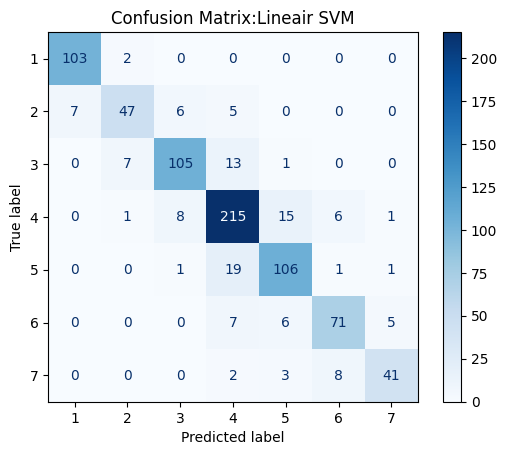

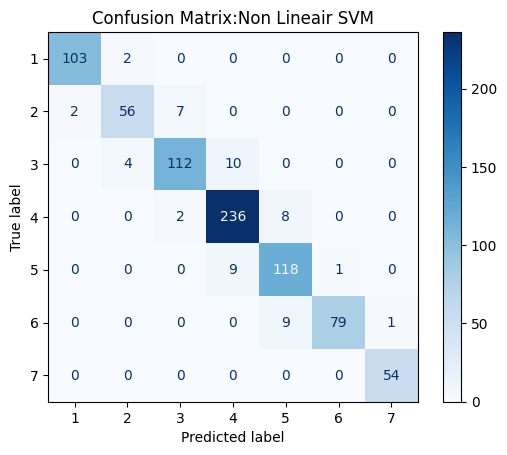

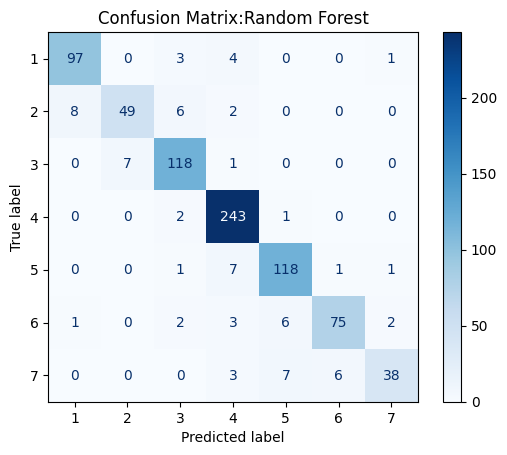

In [ ]:
def apply_all_methods(X_train,Y_train,Y_test,methods):
  index = ['All methods']
  data = {'Acc': ['-'],
          'NMI': ['-'],
          'F1_score': ['-'],
          'AUC': ['-']          }
  df = pd.DataFrame(data,index=['Modeles'])
  resultat_methods={}
  Roc={}
  for name, method in methods.items():
    model = method['model']
    model.fit(X_train, Y_train)
    model_y_scores =model.predict_proba(X_test)
    model_y_pred = model.predict(X_test)
    resultat_methods[name]=metrics_evaluation(Y_test,model_y_pred,model_y_scores)

    df.loc[name] = resultat_methods[name]
    fpr_avg,tpr_avg=comput_fpr_tpr(resultat_methods[name],Y_test,model_y_scores)
    Roc[name]=((fpr_avg,tpr_avg))

    cm = confusion_matrix(Y_test, model_y_pred)

    # Display the confusion matrix with a title
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(Y_test))
    disp.plot(cmap='Blues', values_format='d')
    # Add a title to the plot
    plt.title('Confusion Matrix:'+name)
  return df,Roc
final_df,final_Roc=apply_all_methods(X_train,Y_train,Y_test,methods)

**Tableau récapitulatif des résultats  des modèles appliqués sur la matrice X**

In [ ]:
final_df

Acc       NMI  F1_score       AUC
Modeles                     -         -         -         -
Logistic Regression  0.939729  0.861223  0.932934  0.995971
KNN                  0.873309  0.794452  0.826482  0.987941
CART                      1.0       1.0       1.0       1.0
XGB                       1.0       1.0       1.0       1.0
Naive_Bayes          0.906519   0.81171  0.897593  0.937434
LDA                  0.538745   0.23709  0.527366  0.826274
QDA                  0.124231  0.014285  0.071335  0.493258
Lineair SVM          0.846248  0.687605  0.837757   0.97319
Non Lineair SVM      0.932349  0.852575  0.933559  0.994626
Random Forest        0.907749  0.790554  0.882206  0.986324

En analysant le tableau, les scores accuracy, F1-score, NMI et l’aire sous la courbe (AUC)
obtenus pour la plupart des modèles de classification révèlent généralement des résultats significatifs. En particulier, les modèles CART et XGB ont obtenu des scores atteignant 100 %, tout comme les modèles de régression logistique et de Random forest qui ont affiché des résultats dépassant les 90 %. En revanche, les modèles LDA et QDA présentent des résultats relativement plus faibles.

**Visualisations de la courbe ROC de tous les modèles appliqués sur la matrice X**

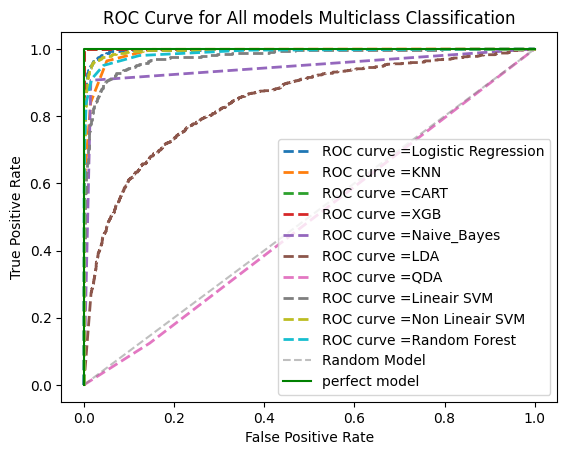

In [ ]:
# Plot
Plot_all_ROC(final_Roc)

En analysant la courbe ROC des modèles de classification appliqués à la matrice X, il est observé que la plupart des modèles ont obtenu un bon score d’aire sous la courbe (AUC) dépassant 80 %. Cependant, la courbe du modèle QDA, en marron, montre des performances légèrement inférieures, ce qui est cohérent avec son AUC atteignant 50%.


**Matrice X équilibré**

Comme mentionné précédemment dans la section, notre jeu de données Cora présente un léger déséquilibre entre les classes. Pour remédier à cela, nous avons utilisé la méthode SMOTE (Synthetic Minority Over-sampling Technique), une technique de suréchantillonnage synthétique qui équilibre les classes en générant artificiellement des exemples de la classe minoritaire.

**Appliquation de la technique SMOTE à l'ensemble d'entraînement**

In [ ]:
smote = SMOTE(sampling_strategy='auto', random_state=42, k_neighbors=5)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

La figure ci-dessous illustre les résultats obtenus après l’application de la technique SMOTE

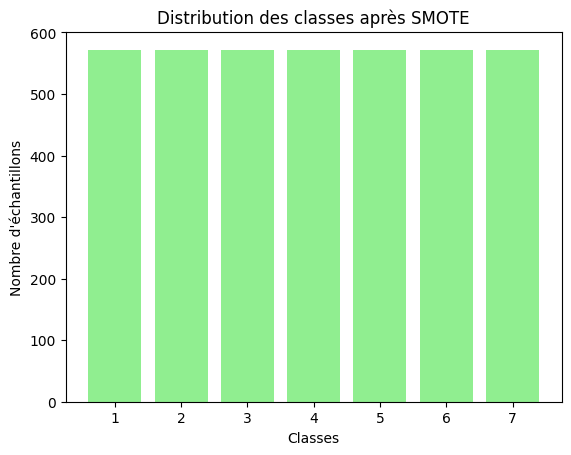

In [ ]:
unique_classes_resampled, class_counts_resampled = np.unique(y_train_resampled, return_counts=True)
plt.bar(unique_classes_resampled, class_counts_resampled, color='lightgreen')
plt.title("Distribution des classes après SMOTE")
plt.xlabel('Classes')
plt.ylabel('Nombre d\'échantillons')
plt.show()

Aprés l'application de la technique SMOTE , nous voyons que les classes du dataset cora sont équilibré à 100%

**Application des modèles de classification sur la matrice X équilibrée**

Déterminer la valeur de K pour le modèle KNN

In [ ]:
best_k=find_k_Grid_search(X_train_resampled,y_train_resampled)

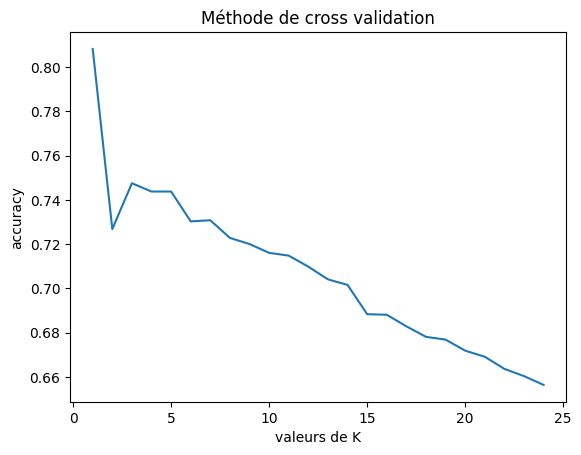

Le meilleur K est: 1


In [ ]:
find_k_Cross_validation(X_train_resampled,y_train_resampled)

**Application des modèles de classification sur la matrice X équilibrée**

À présent, nous mettons en œuvre divers modèles d'apprentissage supervisé sur la matrice X et comparons leurs performances en utilisant différentes métriques d'évaluation.

In [ ]:
S_methods = {}
S_methods['Logistic Regression'] = {'model': LogisticRegression(), 'results': {}}
S_methods['KNN'] = {'model': KNeighborsClassifier(n_neighbors=best_k), 'results': {}}
S_methods['CART'] = {'model': DecisionTreeClassifier(criterion='gini',
                                 random_state=42,
                                 min_samples_split=2,
                                 ), 'results': {}}
S_methods['XGB'] = {'model':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 min_samples_split=2,random_state=0)
, 'results': {}}
S_methods['Naive_Bayes'] = {'model':GaussianNB(), 'results': {}}
S_methods['LDA'] = {'model':LinearDiscriminantAnalysis(), 'results': {}}
S_methods['QDA'] = {'model': QuadraticDiscriminantAnalysis(), 'results': {}}
S_methods['Lineair SVM'] = {'model':OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())), 'results': {}}
S_methods['Non Lineair SVM'] = {'model': OneVsRestClassifier(CalibratedClassifierCV(SVC())), 'results': {}}
S_methods['Random Forest'] = {'model': RandomForestClassifier(criterion='gini',
                                 n_estimators=10,
                                 random_state=1,
                                 min_samples_split=2,
                                 n_jobs=2), 'results': {}}

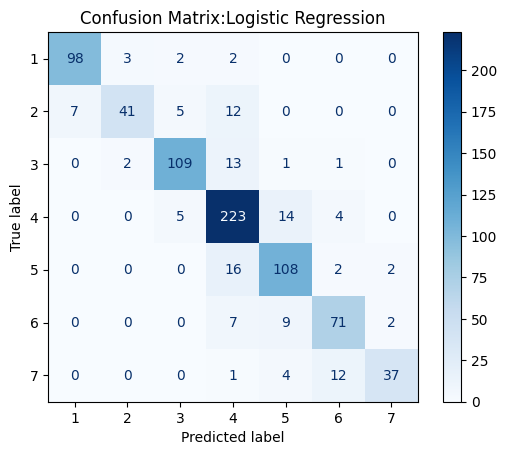

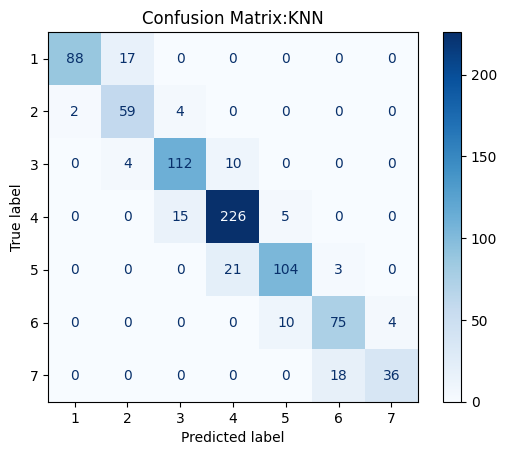

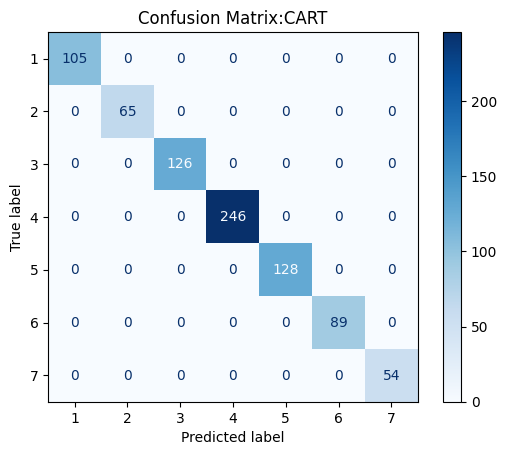

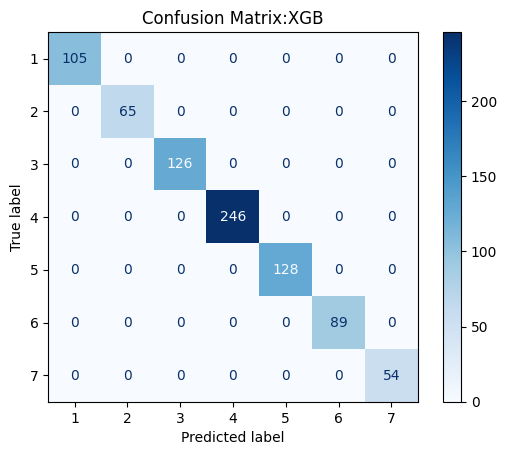

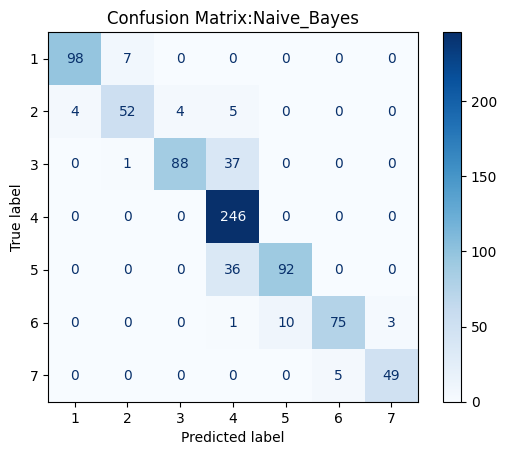

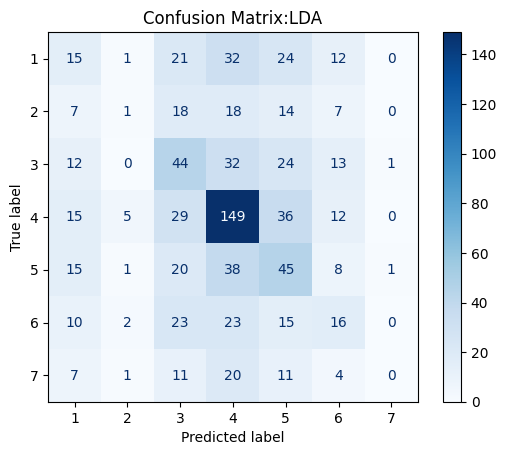

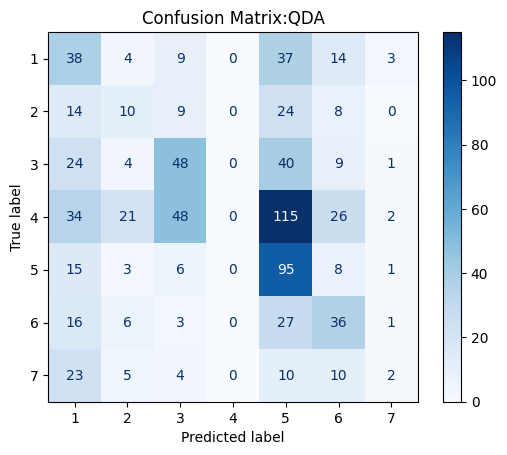

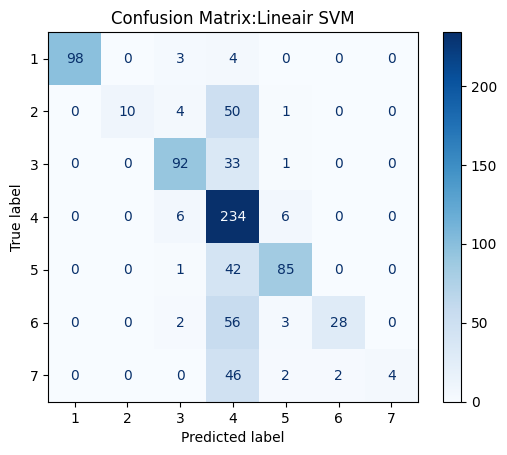

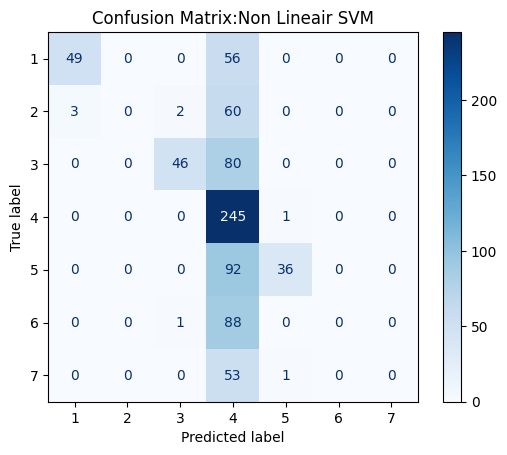

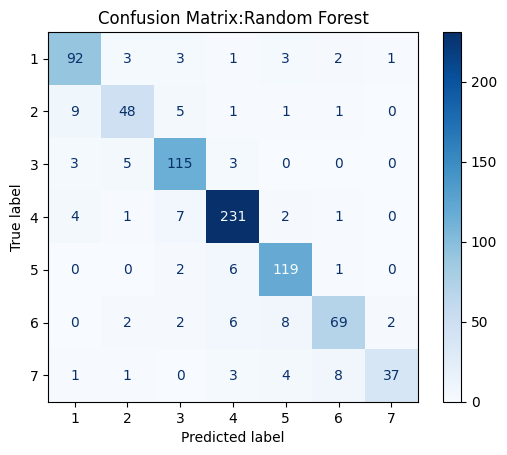

In [ ]:
S_df,S_Roc=apply_all_methods(X_train_resampled,y_train_resampled,Y_test,S_methods)

**Le tableau suivant montre les résultats obtenus des modèles de classification appliqués sur la matrice X équilibré**

In [ ]:
S_df

Acc       NMI  F1_score       AUC
Modeles                     -         -         -         -
Logistic Regression  0.845018  0.683489  0.828969  0.983262
KNN                  0.861009  0.754741  0.843633   0.90756
CART                      1.0       1.0       1.0       1.0
XGB                       1.0       1.0       1.0       1.0
Naive_Bayes          0.861009  0.767225  0.865707   0.91277
LDA                  0.332103  0.042822  0.217831  0.616205
QDA                  0.281673   0.07698  0.236161  0.588955
Lineair SVM          0.677737  0.511873  0.576781  0.963763
Non Lineair SVM      0.462485  0.252694  0.302323  0.968826
Random Forest        0.874539  0.709549  0.847767  0.981147

En analysant les résultats des scores obtenus (Accuracy, F1-score, NMI et l'aire sous la courbe (AUC)), il est observé qu’il y a une baisse significative des performances des modèles appliqués sur la matrice X équilibrée par rapport aux résultats obtenus sur la matrice X originale. Ainsi, il est constaté que l’approche de rééquilibrage des classes n’a pas réussi à améliorer les performances des modèles.

 **Visualisations de la courbe ROC de tous les modèles appliqués sur la matrice X équilibrée**

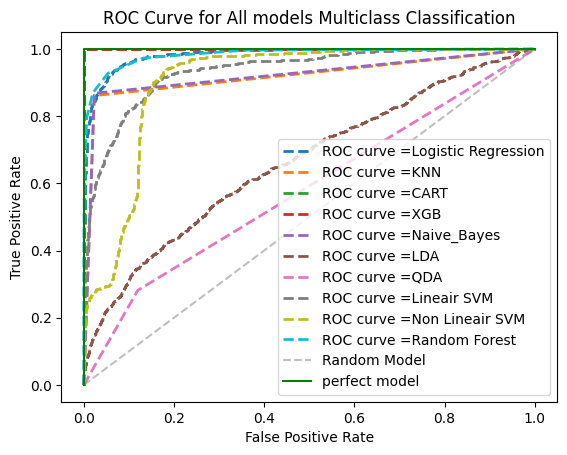

In [ ]:
Plot_all_ROC(S_Roc)

# 2- Combinaison de la matrcie X avec la matrice d’adjacence A
Afin d’obtenir des meilleurs résultats de classification, nous avons combiné la matrice d’attribut X avec la matrice d’adjacence A en utilisant les agrégation suivantes :


1.   F1 : Cette formule est basée sur l’utilisation de la matrice D, qui représente l’inverse de la matrice diagonale des degrés de A.

                 F 1 = (D−1 · A) · X
                 


2.   F2 : Cette fonction d’agrégation est basée sur le produit matriciel entre la matrice X et la matrice A.
                       F 2= A@X


3.   F3 : Cette fonction est semblable à F1, mais avec une différence : le résultat est obtenu en élevant la matrice diagonale des degrés inverses D−1 · A à la puissance p (ordre de propagation)

                   F 3 = (D−1 · A)p · X

  






**Modèles de classification sur la matrice combinée**

In [ ]:
# Inv(D) of A
def Inv_D(A):
  # a diagonal matrix D with the row-sum of A
  rowsum = np.array(A.sum(1))
  # compute 1/rowsum (invers)
  r_inv = np.power(rowsum, -1).flatten()
  r_inv[np.isinf(r_inv)] = 0.
  # make 1/rowsum as diagonal of D
  D_inv = sp.diags(r_inv)
  return D_inv

# normalize A matrix (adjancency) with Inv(D)
def normalize_A_with_D(A):
  return Inv_D(A)@A

# X matrix normalization with tf-if , L2

def normalize_X(X, Tf_idf, L2):
  X2=X
  if Tf_idf==True:
    vectorizer=TfidfTransformer()
    X2 = vectorizer.fit_transform(X2).toarray()


  if L2==True:
     x_norm=np.linalg.norm(X2, axis=1,keepdims=True)
     # Divide x by its norm.
     X2 = X2 / x_norm


  return X2

**Création de la fonction d'aggrégation F1  M=D^(-1)*W * X**

In [ ]:
def fct_agg1(A,X,Tf_idf,L2):
  A_norm=normalize_A_with_D(A)
  X_norm=normalize_X(X,Tf_idf, L2)
  return A_norm@X_norm

Application de la fonction sur X et A (matrcie d'adjacence)

In [ ]:
MC=fct_agg1(A,X,False,False)

In [ ]:
MC_df = pd.DataFrame(MC)
MC_df

0     1     2     3         4     5     6     7     8     9     ...  \
0      0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
1      0.0   0.0   0.0   0.0  0.333333   0.0   0.0   0.0   0.0   0.0  ...   
2      0.0   0.0   0.0   0.0  0.000000   0.0   0.2   0.0   0.0   0.0  ...   
3      0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
4      0.0   0.2   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
...    ...   ...   ...   ...       ...   ...   ...   ...   ...   ...  ...   
2703   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
2704   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
2705   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
2706   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   
2707   0.0   0.0   0.0   0.0  0.000000   0.0   0.0   0.0   0.0   0.0  ...   

      1423  1424  1425  1426  1427  1428  1429  1430      1431  1432  
0      0.0   0.0  0.00   0.0   0.0   0.0   0.0   0.0  0.333333   0.0  
1      0.0   0.0  0.00   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  
2      0.2   0.0  0.00   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  
3      0.0   0.0  0.00   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  
4      0.0   0.0  0.00   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...       ...   ...  
2703   0.0   0.0  0.00   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  
2704   0.0   1.0  0.00   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  
2705   0.0   0.0  0.00   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  
2706   0.0   0.0  0.25   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  
2707   0.0   0.0  0.50   0.0   0.0   0.0   0.0   0.0  0.000000   0.0  

[2708 rows x 1433 columns]

**Partitionnement de l'ensemble de données en Trainset et Testset**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(MC_df,Y_df,test_size=0.3,random_state = 123, stratify =Y_df)

**Application des modèles supervisé sur la matrcie Combinée F1**

Déterminer la valeur de K pour le modèle KNN

Avec la technique de Gridsearch

In [ ]:
best_k=find_k_Grid_search(X_train,Y_train)
print("Meilleur k trouvé : ", best_k)

Meilleur k trouvé :  5


Avec Cross validation

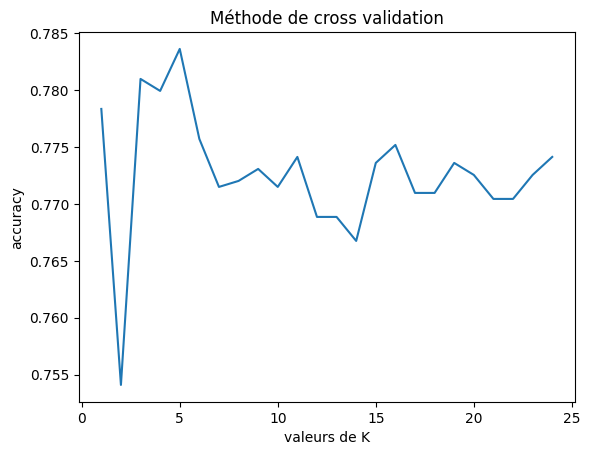

Le meilleur K est: 5


In [ ]:
find_k_Cross_validation(X_train,Y_train)

Mise en œuvre des modèles sur les données d'entraînement, suivie de leur évaluation sur les données de test en utilisant les métriques telles que l'exactitude (Accuracy), l'indice de similarité normalisé (NMI), le score F1, l'Aire sous la courbe (AUC), ainsi que la matrice de confusion.

In [ ]:
MC_methods = {}
MC_methods['Logistic Regression'] = {'model': LogisticRegression(), 'results': {}}
MC_methods['KNN'] = {'model': KNeighborsClassifier(n_neighbors=best_k), 'results': {}}
MC_methods['CART'] = {'model': DecisionTreeClassifier(criterion='gini',
                                 random_state=42,
                                 min_samples_split=2,
                                 ), 'results': {}}
MC_methods['XGB'] = {'model':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 min_samples_split=2,random_state=0)
, 'results': {}}
MC_methods['Naive_Bayes'] = {'model':GaussianNB(), 'results': {}}
MC_methods['LDA'] = {'model':LinearDiscriminantAnalysis(), 'results': {}}
MC_methods['QDA'] = {'model': QuadraticDiscriminantAnalysis(), 'results': {}}
MC_methods['Lineair SVM'] = {'model':OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())), 'results': {}}
MC_methods['Non Lineair SVM'] = {'model': OneVsRestClassifier(CalibratedClassifierCV(SVC())), 'results': {}}
MC_methods['Random Forest'] = {'model': RandomForestClassifier(criterion='gini',
                                 n_estimators=10,
                                 random_state=1,
                                 min_samples_split=2,
                                 n_jobs=2), 'results': {}}

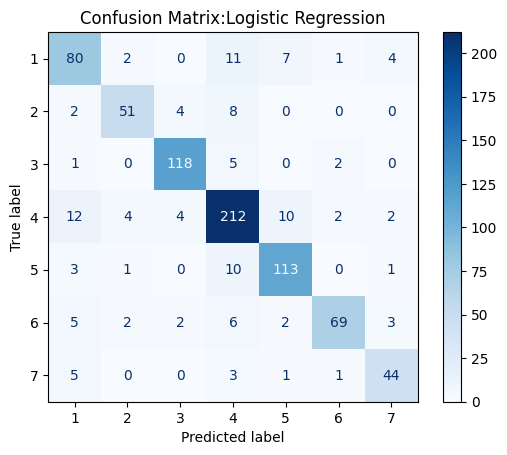

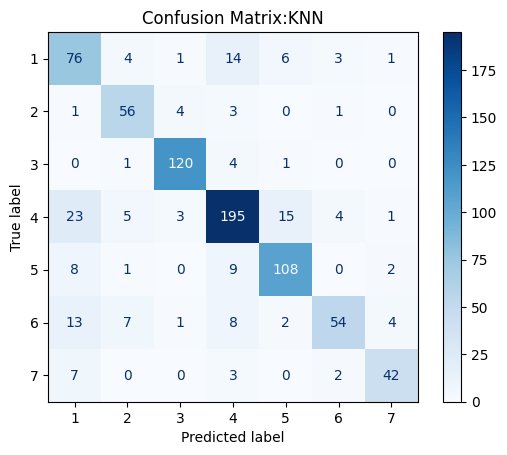

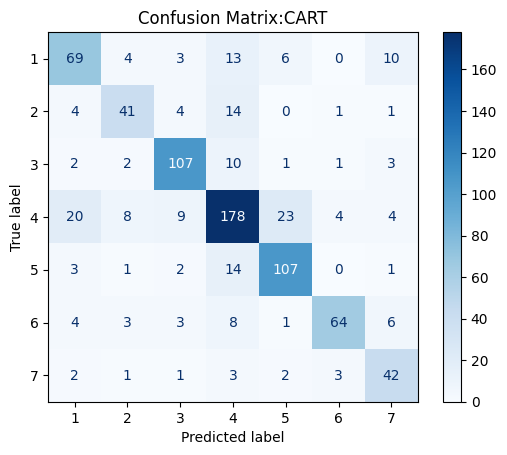

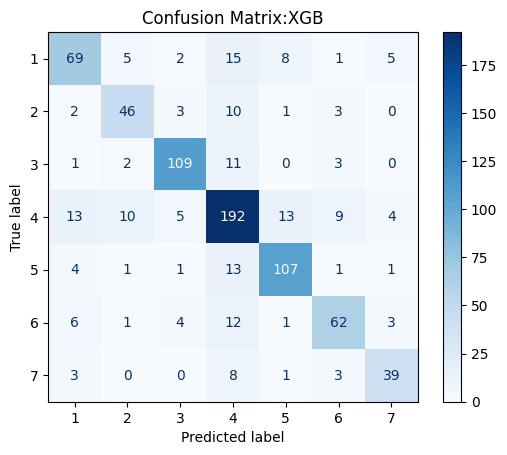

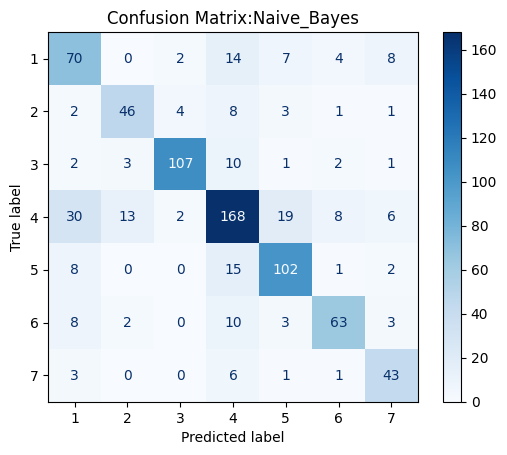

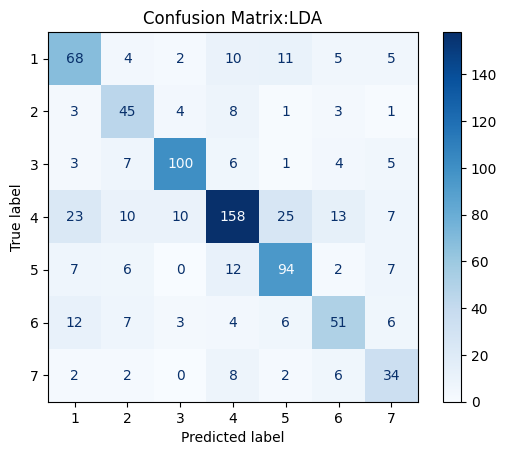

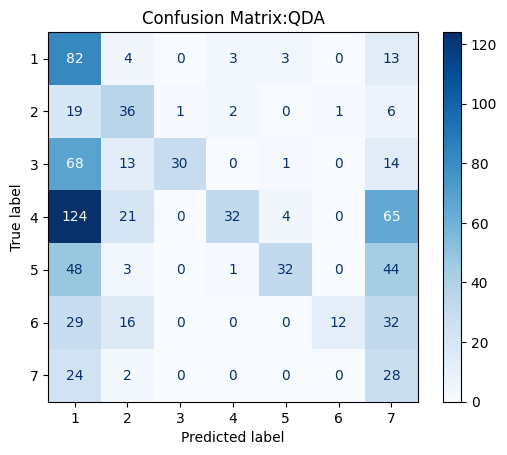

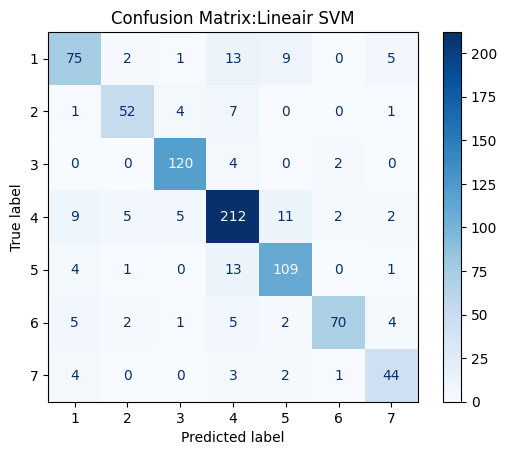

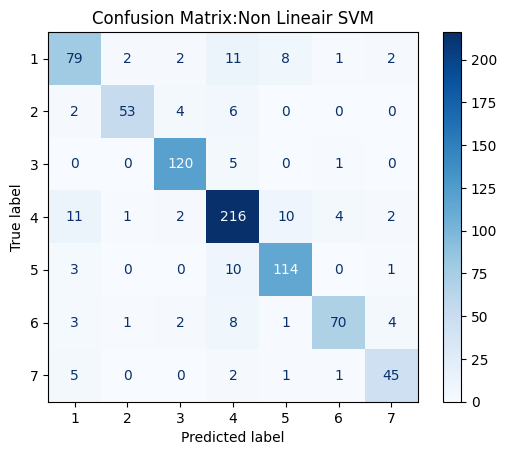

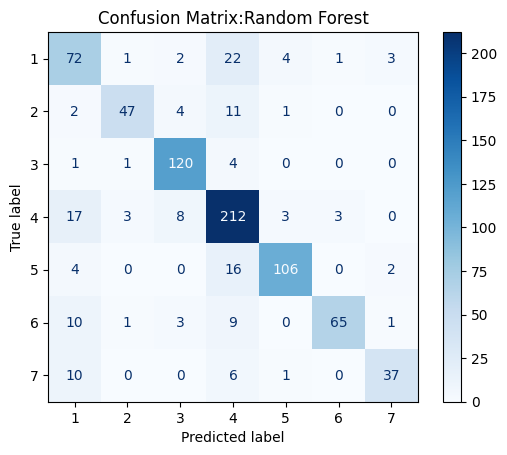

In [ ]:
MC_df,MC_Roc=apply_all_methods(X_train,Y_train,Y_test,MC_methods)

**Tableau récapitulatif des résultats obtenus sur la matrice combinée F1**

Nous présentons dans ce tableau les résultats obtenus sur la matrice combinée en utilisant la fonction de combinaison F1

In [ ]:
MC_df

Acc       NMI  F1_score       AUC
Modeles                     -         -         -         -
Logistic Regression  0.845018  0.652575  0.837828  0.972296
KNN                  0.800738  0.597507  0.793252  0.945971
CART                 0.747847  0.499256  0.738694  0.848917
XGB                  0.767528  0.521092  0.757735  0.912344
Naive_Bayes          0.736777   0.49607  0.738098  0.856504
LDA                  0.676507  0.395502  0.657752  0.869458
QDA                  0.309963  0.177869   0.31731  0.630887
Lineair SVM          0.838868  0.645186  0.830901   0.96571
Non Lineair SVM      0.857319  0.677623  0.852864  0.968495
Random Forest        0.810578  0.613196  0.803561  0.945289

D’après les scores (Accuracy, NMI, F1-score et AUC) obtenus dans le tableau ci-dessus,nous constatons que la fonction d’agrégation F1 a amélioré les résultats de certains modèles, notamment pour les algorithmes LDA et QDA qui ont atteint des scores dépassant respectivement 67 % et 31 % pour l’accuracy, 65 % et 33 % pour le F1-score, 39% et 17% pour NMI et des AUC dépassant respectivement 86 % et 63 %

**Visualisation de la courbe ROC**

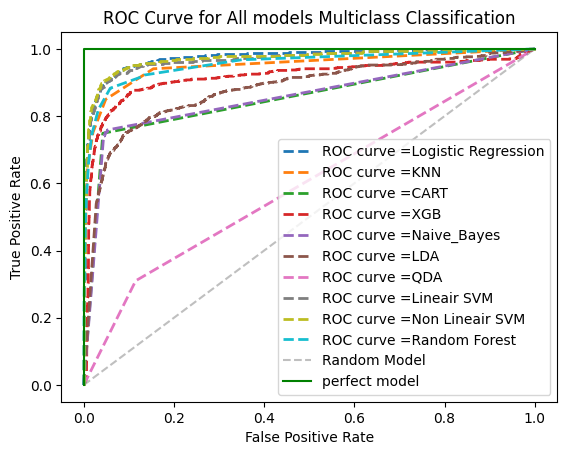

In [ ]:
Plot_all_ROC(MC_Roc)

En observant la courbe ROC des modèles de classification appliqués à la matrice X agrégée par la fonction F1, on remarque une amélioration significative de la courbe pour les modèles LDA et QDA par rapport aux résultats de la matrice X.

#M=D^(-1)*W*X : Combinaison de X et W(A) avec la normalisation de X en utilisant TF-IDF

Dans cette section, Nous présentons les résultats obtenus sur la matrice combinée en utilisant la pondération TF-IDF (Term Frequency-Inverse Document Frequency) sur la matrice X, cette technique permet d’évaluer l’importance d’un terme dans un document par rapport à l’ensemble du corpus.

La fonction fct_agg1 combine les deux matrices en appliquant la technique de normalisation TF-IDF à la matrice X.

In [ ]:
MC_TF_IDF=fct_agg1(A,X,True,False)

In [ ]:
MC_TF_df = pd.DataFrame(MC_TF_IDF)

**Partitionnement de la matrice combinée en train set et test set**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(MC_TF_df,Y_df,test_size=0.3,random_state = 123, stratify =Y_df)

**Appliquation des deux méthodes (Gridsearch et Cross valisation) pour trouver le bon K du modèle KNN**

In [ ]:
best_k=find_k_Grid_search(X_train,Y_train)
print("Meilleur k trouvé : ", best_k)

Meilleur k trouvé :  1


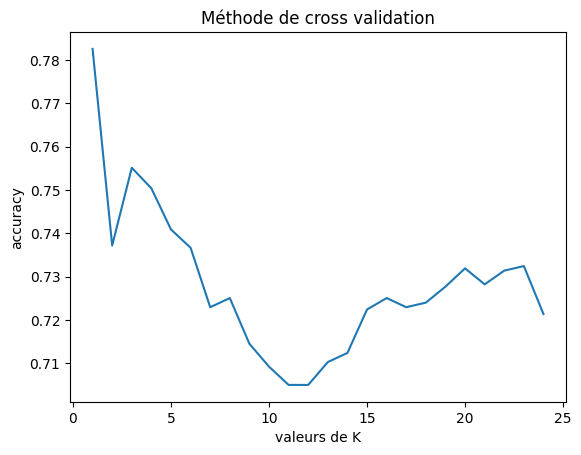

Le meilleur K est: 1


In [ ]:
find_k_Cross_validation(X_train,Y_train)

**Application des modèles de classification sur la matrice combinée**

In [ ]:
MC_TF_methods = {}
MC_TF_methods['Logistic Regression'] = {'model': LogisticRegression(), 'results': {}}
MC_TF_methods['KNN'] = {'model': KNeighborsClassifier(n_neighbors=best_k), 'results': {}}
MC_TF_methods['CART'] = {'model': DecisionTreeClassifier(criterion='gini',
                                 random_state=42,
                                 min_samples_split=2,
                                 ), 'results': {}}
MC_TF_methods['XGB'] = {'model':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 min_samples_split=2,random_state=0)
, 'results': {}}
MC_TF_methods['Naive_Bayes'] = {'model':GaussianNB(), 'results': {}}
MC_TF_methods['LDA'] = {'model':LinearDiscriminantAnalysis(), 'results': {}}
MC_TF_methods['QDA'] = {'model': QuadraticDiscriminantAnalysis(), 'results': {}}
MC_TF_methods['Lineair SVM'] = {'model':OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())), 'results': {}}
MC_TF_methods['Non Lineair SVM'] = {'model': OneVsRestClassifier(CalibratedClassifierCV(SVC())), 'results': {}}
MC_TF_methods['Random Forest'] = {'model': RandomForestClassifier(criterion='gini',
                                 n_estimators=10,
                                 random_state=1,
                                 min_samples_split=2,
                                 n_jobs=2), 'results': {}}

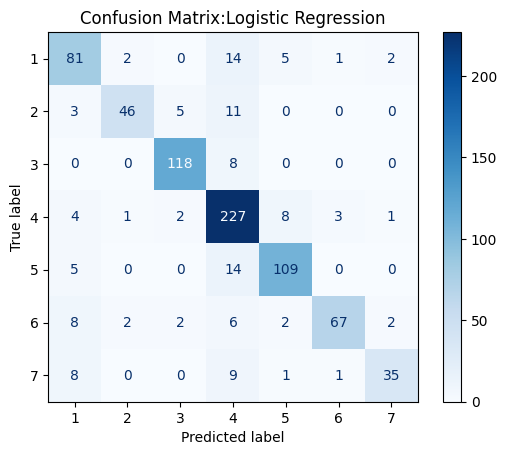

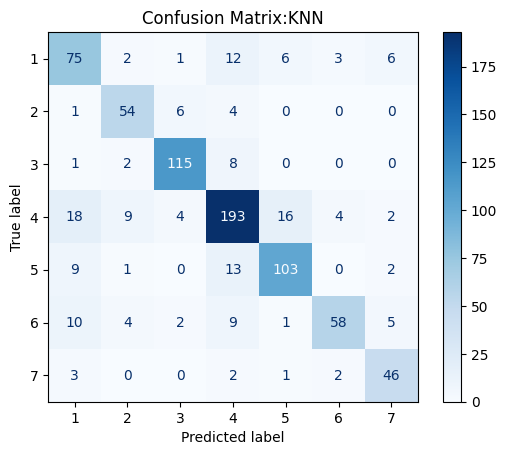

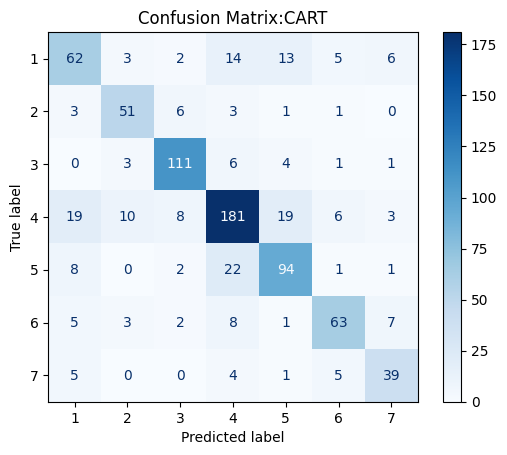

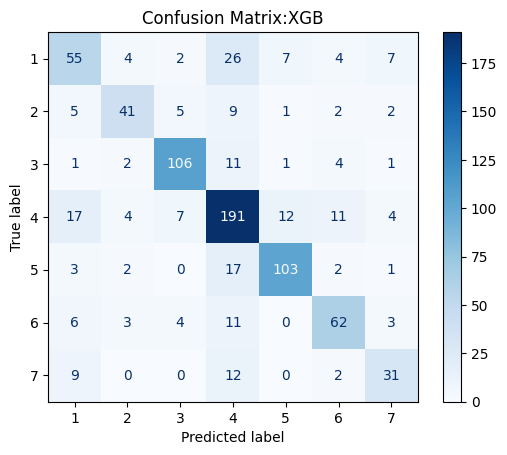

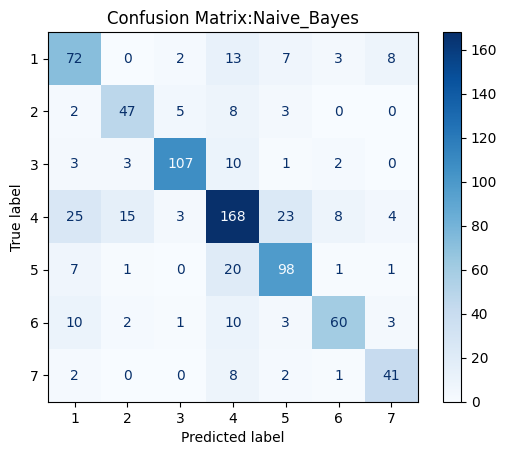

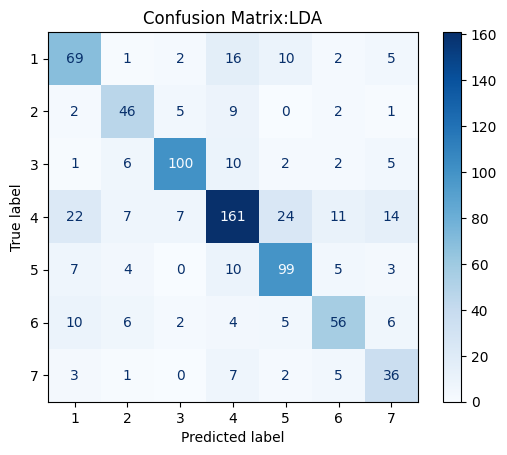

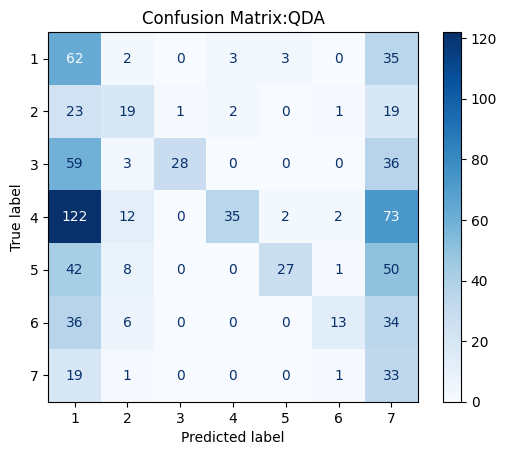

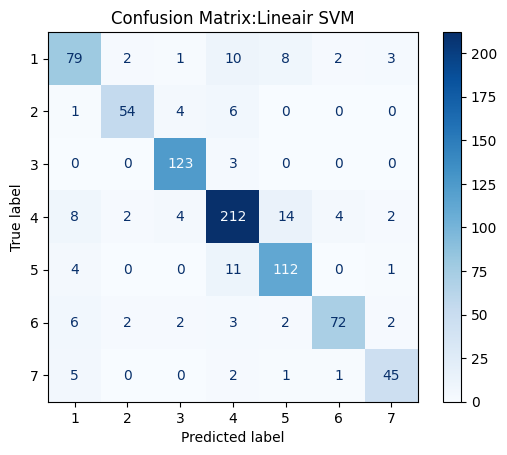

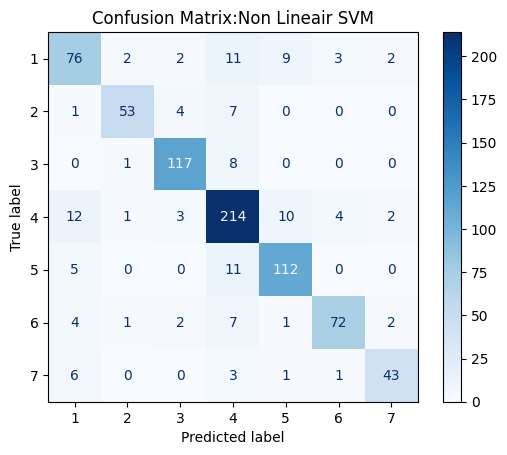

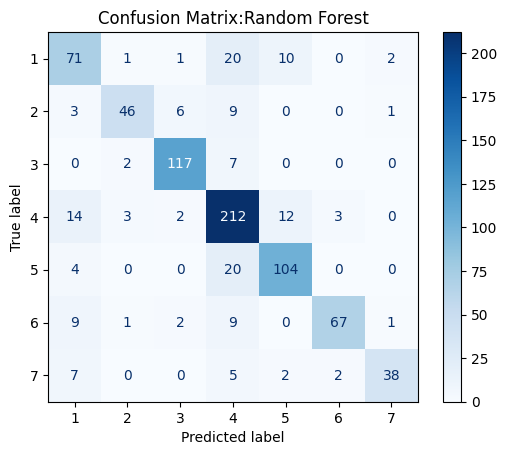

In [ ]:
MC_TF_df,MC_TF_Roc=apply_all_methods(X_train,Y_train,Y_test,MC_TF_methods)

**Résultats des modèles sur la matrice combinée F1 avec TF-
IDF(X)**

In [ ]:
MC_TF_df

Acc       NMI  F1_score       AUC
Modeles                     -         -         -         -
Logistic Regression  0.840098  0.653598  0.824308  0.972945
KNN                  0.792128   0.57668   0.78765   0.87831
CART                 0.739237  0.491833  0.732313  0.845532
XGB                  0.724477  0.463836    0.7039  0.870245
Naive_Bayes          0.729397  0.486299  0.732386  0.846919
LDA                  0.697417  0.427489  0.684809  0.887283
QDA                  0.266913  0.138493  0.282383  0.599826
Lineair SVM          0.857319  0.679538  0.853337   0.97169
Non Lineair SVM      0.845018  0.657504  0.842823  0.966727
Random Forest        0.805658  0.607305  0.801012  0.940213

Suite à l’application de la pondération TF-IDF à la matrice X avec la combinaison F1, nous avons observé dans le tableau une amélioration des résultats pour certains algorithmes en termes de scores (accuracy, NMI, F1-score, AUC), en particulier pour les modèles Linear SVM et LDA . Ces modèles ont obtenu des scores d’accuracy respectivement de 85 % et 69 %, NMI 67% et 42% respectivement, des F1-scores dépassant 85 %, 68 % respectivement et des AUC dépassant 97%, 88%.

**Visualisations de la courbe ROC de tous les modèles appliqués sur la matrice combinée F1 avec TF-IDF(X)**

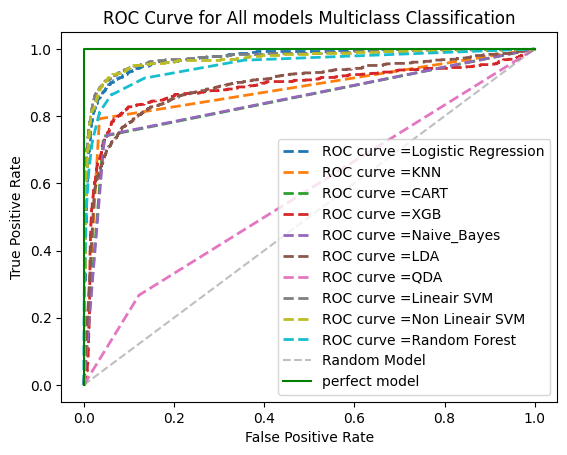

In [ ]:
Plot_all_ROC(MC_TF_Roc)

Selon la courbe ROC des modèles de classification appliqués à la matrice X pondérée par TF-IDF et agrégée par la fonction F1, nous observons une amélioration notable de la courbe pour les modèles LDA et Linear SVM par rapport aux résultats de la matrice F1 sans TF-IDF. Il est à noter que le modèle QDA reste moins performant que les autres modèles.

**Matrice Combinée F1 avec X normalisée par L2**

Nous présentons les résultats obtenus sur la matrice combinée en
utilisant la normalisation euclidienne de vecteurs L2 sur la matrice X. cette normalisation vise à mettre tous les vecteurs sur une même échelle en divisant chaque élément du vecteur par sa norme L2

Cette fois, nous combinos les deux matrices en normalisant X avec L2

In [ ]:
MC_L2=fct_agg1(A,X,False,True)

In [ ]:
MC_L2_df = pd.DataFrame(MC_L2)

**Partitionnement de l'ensemble de données en train set et test set**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(MC_L2_df,Y_df,test_size=0.3,random_state = 123, stratify =Y_df)

**Appliquation des deux méthodes (Gridsearch et Cross validation) pour trouver le bon K du modèle KNN**

In [ ]:
best_k=find_k_Grid_search(X_train,Y_train)
print("Meilleur k trouvé : ", best_k)

Meilleur k trouvé :  1


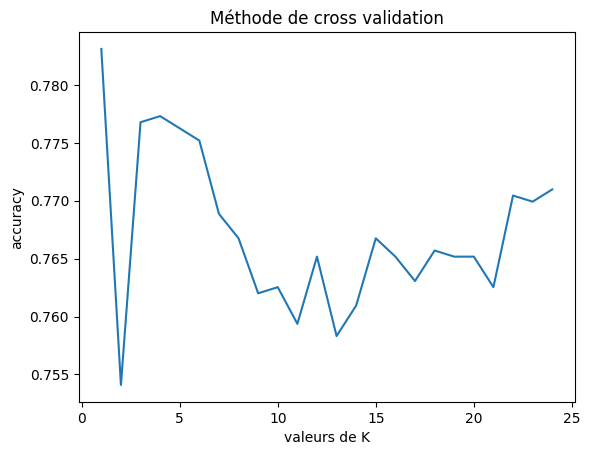

Le meilleur K est: 1


In [ ]:
find_k_Cross_validation(X_train,Y_train)

In [ ]:
MC_L2_methods = {}
MC_L2_methods['Logistic Regression'] = {'model': LogisticRegression(), 'results': {}}
MC_L2_methods['KNN'] = {'model': KNeighborsClassifier(n_neighbors=best_k), 'results': {}}
MC_L2_methods['CART'] = {'model': DecisionTreeClassifier(criterion='gini',
                                 random_state=42,
                                 min_samples_split=2,
                                 ), 'results': {}}
MC_L2_methods['XGB'] = {'model':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 min_samples_split=2,random_state=0)
, 'results': {}}
MC_L2_methods['Naive_Bayes'] = {'model':GaussianNB(), 'results': {}}
MC_L2_methods['LDA'] = {'model':LinearDiscriminantAnalysis(), 'results': {}}
MC_L2_methods['QDA'] = {'model': QuadraticDiscriminantAnalysis(), 'results': {}}
MC_L2_methods['Lineair SVM'] = {'model':OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())), 'results': {}}
MC_L2_methods['Non Lineair SVM'] = {'model': OneVsRestClassifier(CalibratedClassifierCV(SVC())), 'results': {}}
MC_L2_methods['Random Forest'] = {'model': RandomForestClassifier(criterion='gini',
                                 n_estimators=10,
                                 random_state=1,
                                 min_samples_split=2,
                                 n_jobs=2), 'results': {}}

Application des modèles supervisé sur la matrice combinée puis en les évaluant sur train set en utilisant les métriques tels que : NMI, Accuracy, F1_score

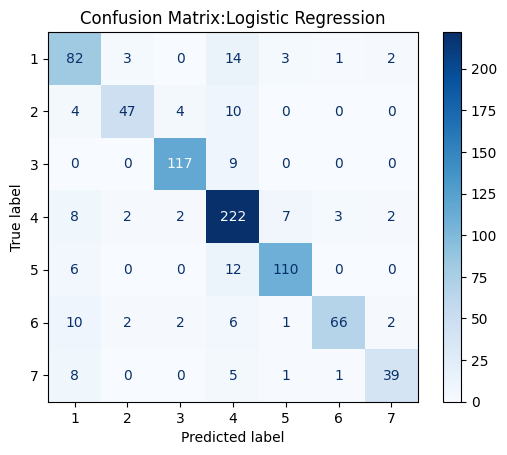

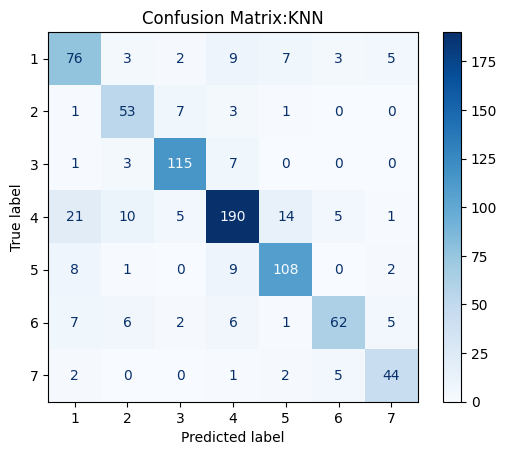

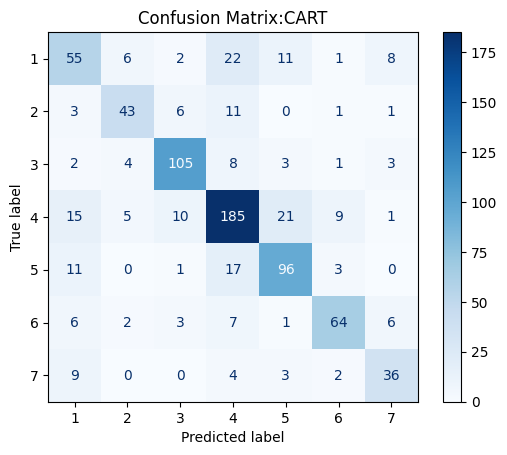

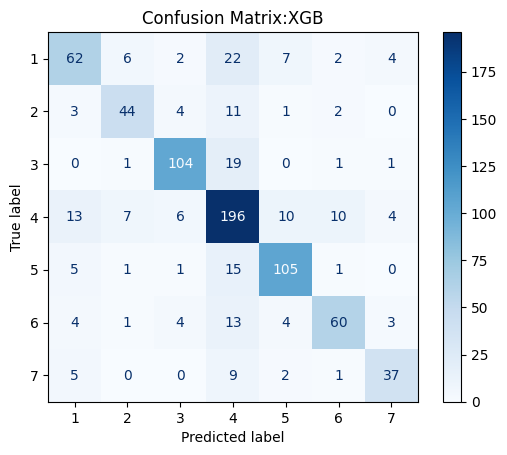

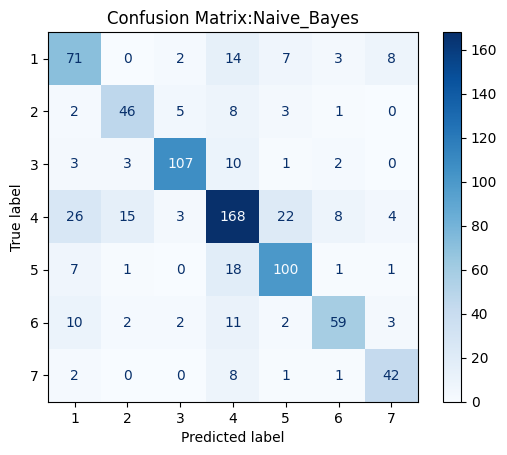

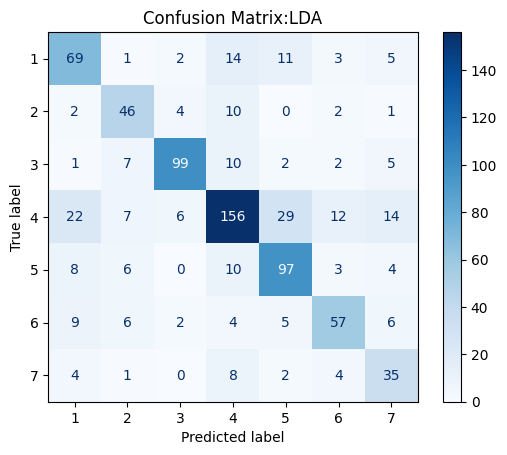

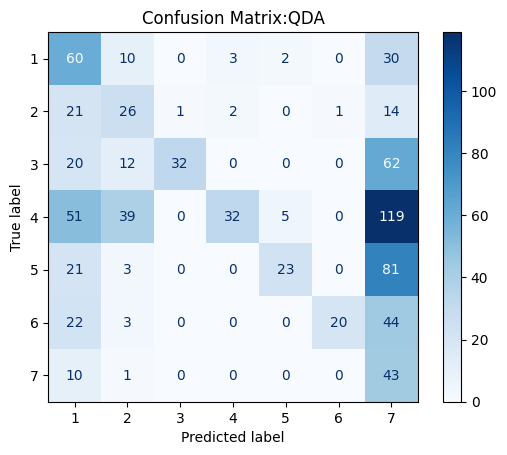

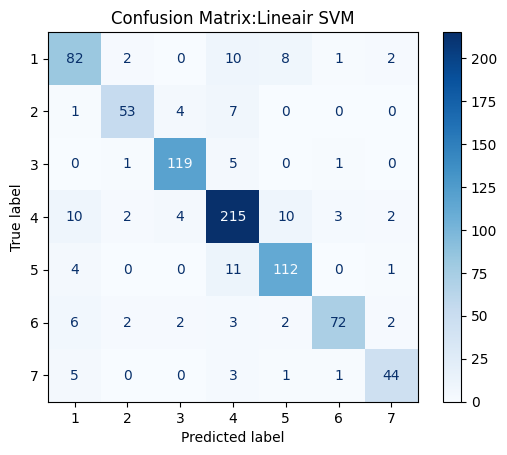

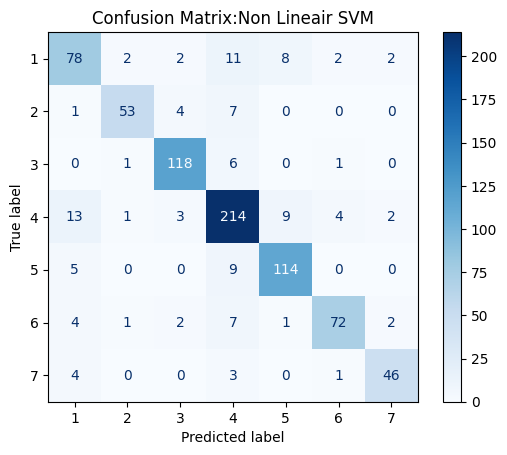

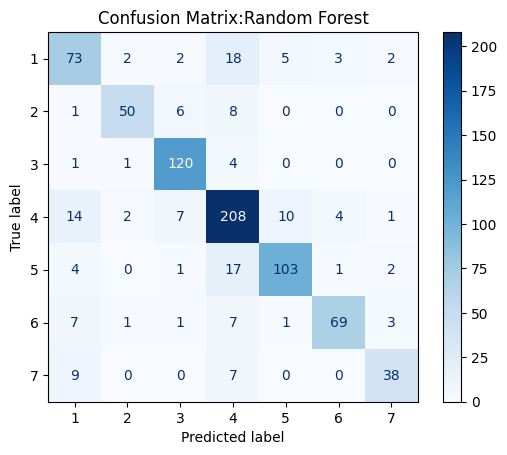

In [ ]:
MC_L2,MC_L2_Roc=apply_all_methods(X_train,Y_train,Y_test,MC_L2_methods)

**Résultats des modèles sur la matrice combinée F1 avec normalisation L2**

In [ ]:
MC_L2

Acc       NMI  F1_score       AUC
Modeles                     -         -         -         -
Logistic Regression  0.840098  0.653178   0.82826  0.971699
KNN                  0.797048  0.582779  0.788253  0.881114
CART                 0.718327  0.460714  0.705079  0.825819
XGB                  0.747847  0.494484  0.738891  0.895427
Naive_Bayes          0.729397  0.485112  0.731643  0.848938
LDA                  0.687577  0.417413  0.676308  0.885352
QDA                  0.290283  0.176923  0.312853  0.626962
Lineair SVM          0.857319  0.676163  0.852842  0.972869
Non Lineair SVM      0.854859  0.673562  0.853993  0.967503
Random Forest        0.813038  0.608195  0.807762  0.938882

Après l’application de la normalisation L2 à la matrice X avec la combinaison F1, en examinant les scores (Accuracy, NMI, F1-score, AUC) figurant dans le tableau ci-dessous, nous avons généralement remarqué qu’il n’y a pas d’amélioration très significative par rapport aux résultats précédents ( avec TF-IDF), à l’exception du modèle
XGB qui a amélioré ses scores d’accuracy, dépassant respectivement 75 %,  NMI dépassant 49%, F1-score dépassant 74 %, et AUC dépassant 90 %

**Visualisations de la courbe ROC de tous les modèles appliqués sur la matrice combinée F1 avec la normalisation L2**

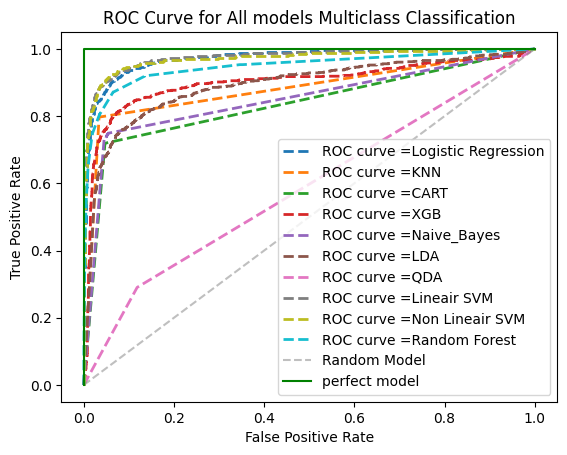

In [ ]:
Plot_all_ROC(MC_L2_Roc)

En examinant le graphique, nous observons que les courbes ROC des modèles appliqués sont similaires à celles que nous avons obtenues avec la matrice combinée F1(TF-IDF). Il est important de souligner qu’il y a une amélioration de l’AUC du modèle QDA, dépassant les 64 %.

#Combinaison de la matrice d'objets X avec la matrice d'adjacence A :A@X

Nous présentons les résultats obtenus des modèles d’apprentissage
supervisé appliqués sur la matrice combinée avec la fonction d’aggrégation F2 = A@X

In [ ]:
M=A@X

In [ ]:
M_df = pd.DataFrame(M)

**Partitionnement de l'ensemble de données**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(M_df,Y_df,test_size=0.3,random_state = 123, stratify =Y_df)

Déterminer la valeur de K pour le modèle KNN

In [ ]:
best_k=find_k_Grid_search(X_train,Y_train)
print("Meilleur k trouvé : ", best_k)

Meilleur k trouvé :  1


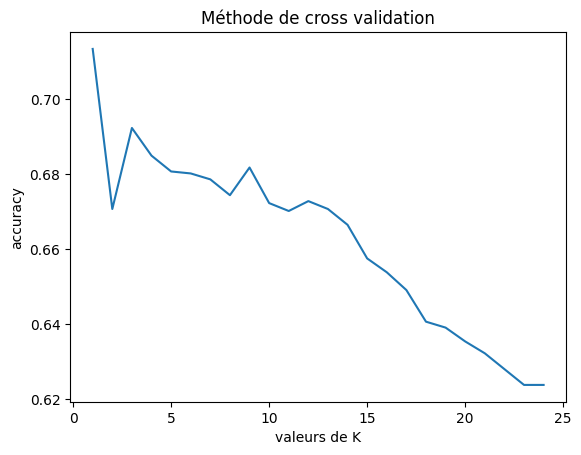

Le meilleur K est: 1


In [ ]:
find_k_Cross_validation(X_train,Y_train)

**L' application des modèles supervisé sur la matrice combinée avec F2**

In [ ]:
M_methods = {}
M_methods['Logistic Regression'] = {'model': LogisticRegression(), 'results': {}}
M_methods['KNN'] = {'model': KNeighborsClassifier(n_neighbors=best_k), 'results': {}}
M_methods['CART'] = {'model': DecisionTreeClassifier(criterion='gini',
                                 random_state=42,
                                 min_samples_split=2,
                                 ), 'results': {}}
M_methods['XGB'] = {'model':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 min_samples_split=2,random_state=0)
, 'results': {}}
M_methods['Naive_Bayes'] = {'model':GaussianNB(), 'results': {}}
M_methods['LDA'] = {'model':LinearDiscriminantAnalysis(), 'results': {}}
M_methods['QDA'] = {'model': QuadraticDiscriminantAnalysis(), 'results': {}}
M_methods['Lineair SVM'] = {'model':OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())), 'results': {}}
M_methods['Non Lineair SVM'] = {'model': OneVsRestClassifier(CalibratedClassifierCV(SVC())), 'results': {}}
M_methods['Random Forest'] = {'model': RandomForestClassifier(criterion='gini',
                                 n_estimators=10,
                                 random_state=1,
                                 min_samples_split=2,
                                 n_jobs=2), 'results': {}}

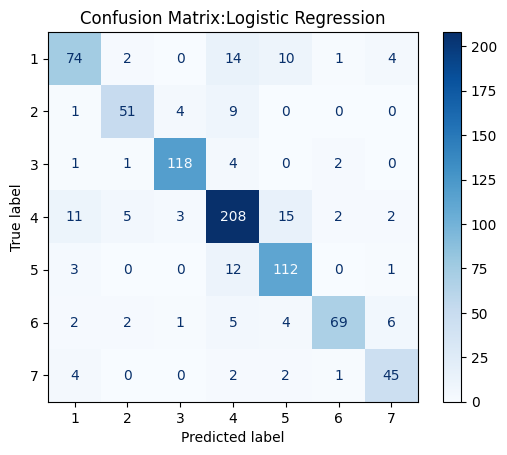

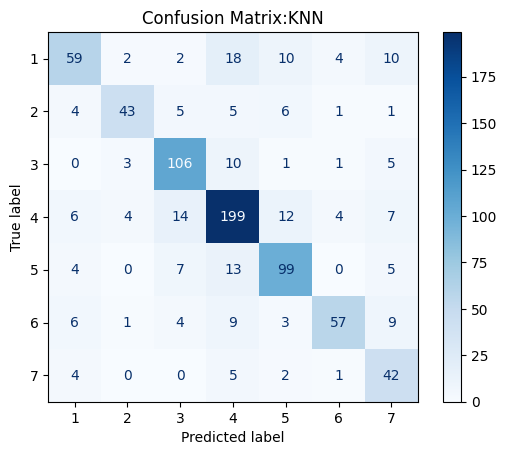

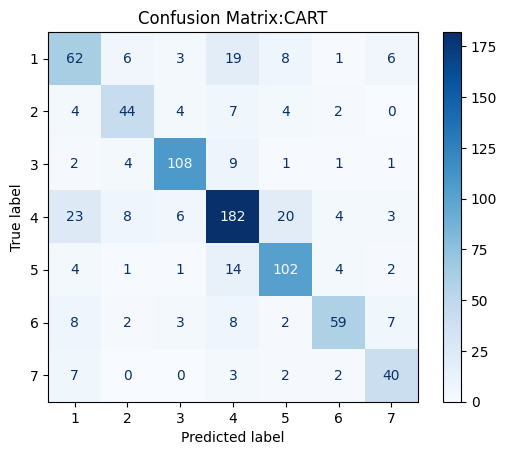

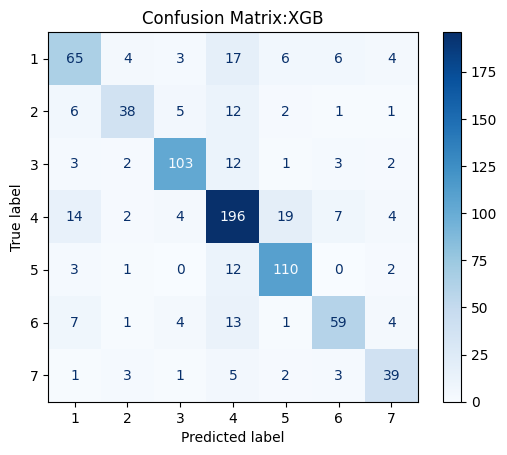

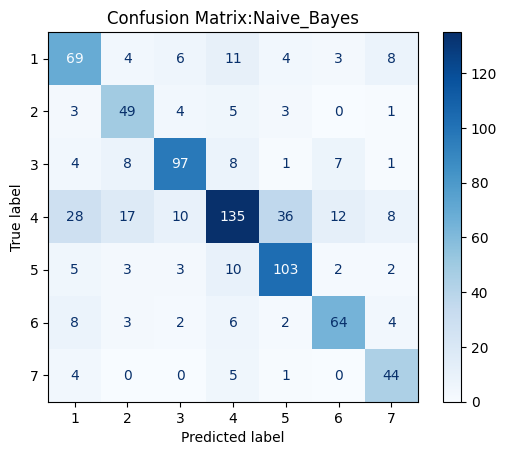

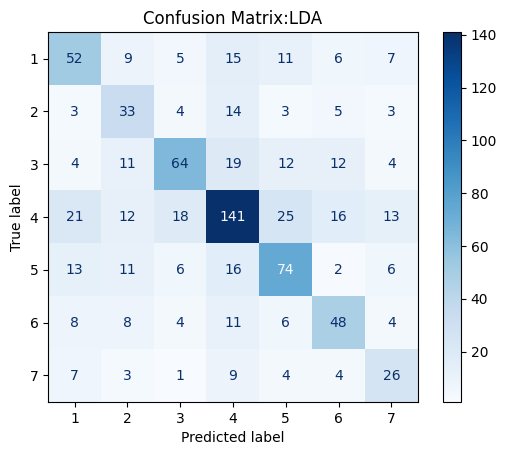

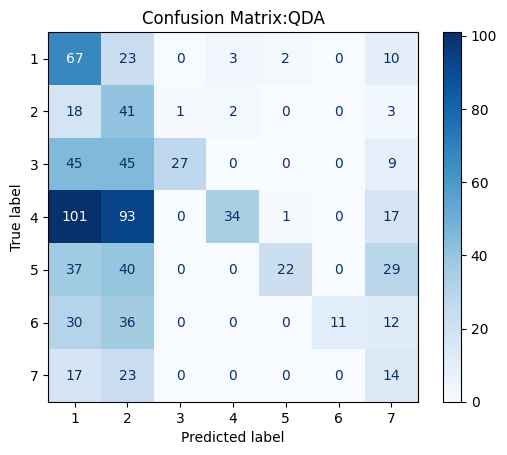

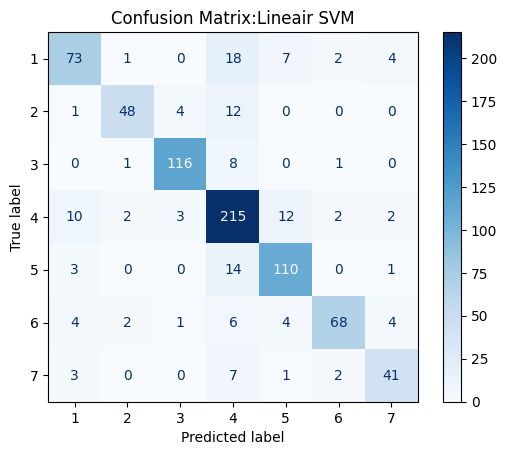

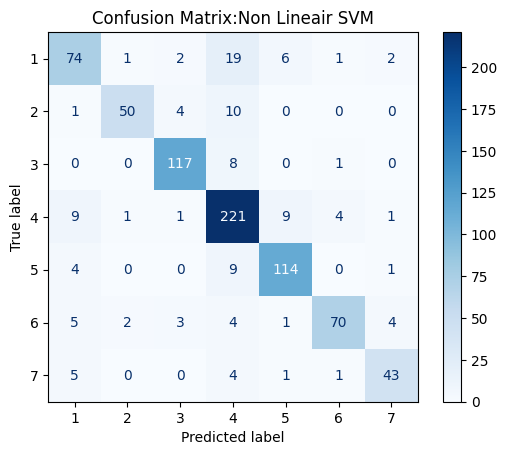

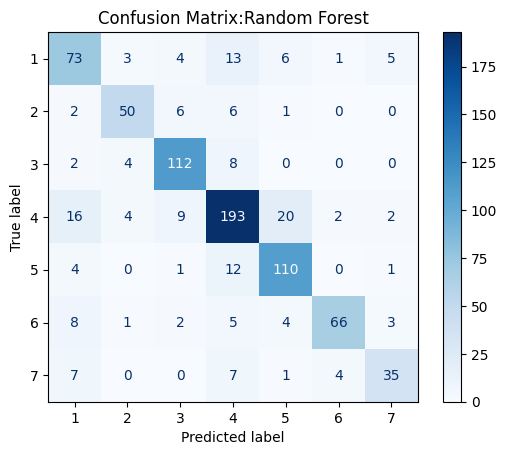

In [ ]:
M_df,M_Roc=apply_all_methods(X_train,Y_train,Y_test,M_methods)

**Résultats des modèles sur la matrice combinée F2**

In [ ]:
M_df

Acc       NMI  F1_score       AUC
Modeles                     -         -         -         -
Logistic Regression  0.832718  0.639559  0.826565     0.962
KNN                  0.744157  0.481303   0.72342  0.839434
CART                 0.734317  0.476679  0.722933  0.839794
XGB                  0.750308   0.48934  0.731896  0.883109
Naive_Bayes          0.690037   0.43225  0.695697  0.847534
LDA                  0.538745  0.216478  0.516751  0.801983
QDA                  0.265683  0.134249  0.261301  0.597011
Lineair SVM          0.825338   0.62621  0.818347   0.95866
Non Lineair SVM      0.847478  0.664281  0.840771  0.967925
Random Forest        0.785978  0.558569  0.777019  0.944084

D’après les scores (Accuracy, NMI, F1-score et AUC) obtenus dans le tableau ci-dessus,nous observons que la fonction d’agrégation F2 a amélioré les résultats de certains mdèles par rapport à ceux de la matrice originale. En particulier, les algorithmes LDA et QDA ont atteint des scores dépassant respectivement 53 % et 27 % pour l’accuracy, 21% et 31% pour le NMI, 51 % et 26 % pour le F1-score, ainsi que des AUC dépassant respectivement 80 % et 60 %. Cependant, il est notable que les résultats obtenus avec la matrice combinée F2 sont moins performants que ceux avec la matrice combinée F1

**Visualisation de la courbe ROC**

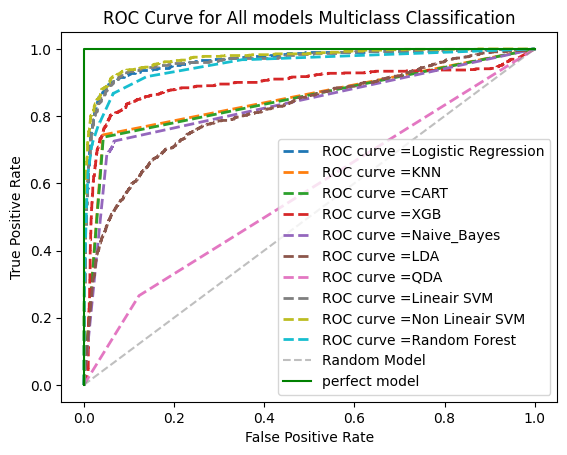

In [ ]:
Plot_all_ROC(M_Roc)

En examinant les courbes ROC ci-dessous des modèles de classification appliqués à la matrice X agrégée par la fonction F2, nous constatons que certains modèles présentent des courbes proches de la courbe parfaite. En particulier, Logistic Regression,Linear SVM et Non-Linear SVM se distinguent avec des AUC dépassant 90 %. Cependant, la courbe QDA demeure moins performante en raison de son score AUC qui est de 60 %. Il est important de noter que les courbes ROC obtenues sont généralement moins performantes que celles obtenues avec la matrice combinée F1.

#Combinaison de X et A en utilisant la fonction d'aggrégation F3:
Nous présentons les résultats obtenus des modèles d’apprentissage
supervisé appliqués sur la matrice combinée avec la fonction d’aggrégation F3

Suite à une variation de la valeur de \(P\), nous avons choisi \(P = 2\) en raison de son impact positif sur les résultats, notamment en termes d'accuracy, de NMI (Information Mutuelle Normalisée) et de F1-score.



**Création de la fonction d'aggrégation F3**

In [ ]:
def fct_agg3(A,X,p):
  A_norm=normalize_A_with_D(A)
  A_norm=np.power(A_norm, p)
  X_norm=normalize_X(X,False, False)
  return A_norm@X_norm

In [ ]:
M_F3=fct_agg3(A,X,2)
M_F3_df = pd.DataFrame(M_F3)

**Partitionnement de l'ensemble de données**

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(M_F3_df,Y_df,test_size=0.3,random_state = 123, stratify =Y_df)

**Déterminer la valeur de K pour le modèle KNN**

In [ ]:
best_k=find_k_Grid_search(X_train,Y_train)
print("Meilleur k trouvé : ", best_k)

Meilleur k trouvé :  1


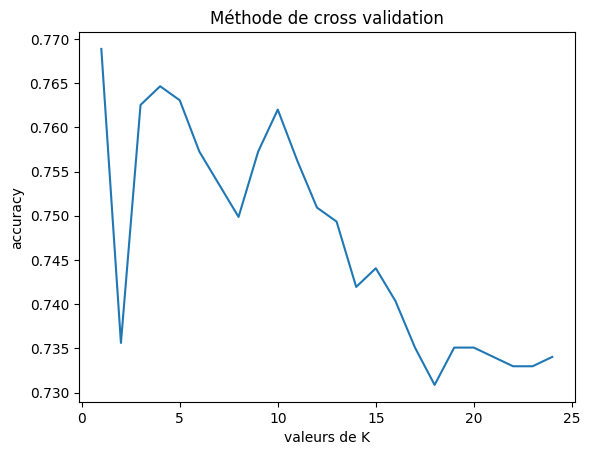

Le meilleur K est: 1


In [ ]:
find_k_Cross_validation(X_train,Y_train)

**L' application des modèles supervisé sur la matrice combinée avec F3**

In [ ]:
MF3_methods = {}
MF3_methods['Logistic Regression'] = {'model': LogisticRegression(), 'results': {}}
MF3_methods['KNN'] = {'model': KNeighborsClassifier(n_neighbors=best_k), 'results': {}}
MF3_methods['CART'] = {'model': DecisionTreeClassifier(criterion='gini',
                                 random_state=42,
                                 min_samples_split=2,
                                 ), 'results': {}}
MF3_methods['XGB'] = {'model':GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                 min_samples_split=2,random_state=0)
, 'results': {}}
MF3_methods['Naive_Bayes'] = {'model':GaussianNB(), 'results': {}}
MF3_methods['LDA'] = {'model':LinearDiscriminantAnalysis(), 'results': {}}
MF3_methods['QDA'] = {'model': QuadraticDiscriminantAnalysis(), 'results': {}}
MF3_methods['Lineair SVM'] = {'model':OneVsRestClassifier(CalibratedClassifierCV(LinearSVC())), 'results': {}}
MF3_methods['Non Lineair SVM'] = {'model': OneVsRestClassifier(CalibratedClassifierCV(SVC())), 'results': {}}
MF3_methods['Random Forest'] = {'model': RandomForestClassifier(criterion='gini',
                                 n_estimators=10,
                                 random_state=1,
                                 min_samples_split=2,
                                 n_jobs=2), 'results': {}}

**Résultats des modèles sur la matrice combinée F3**

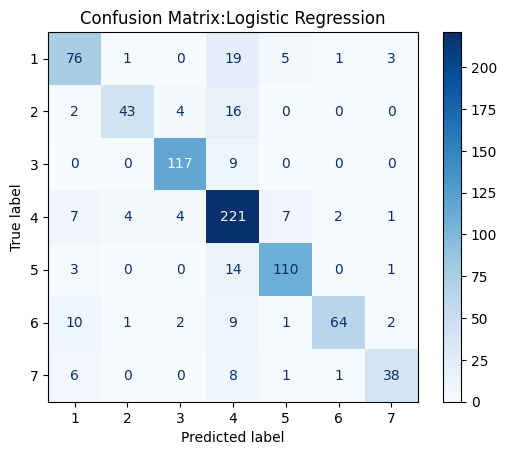

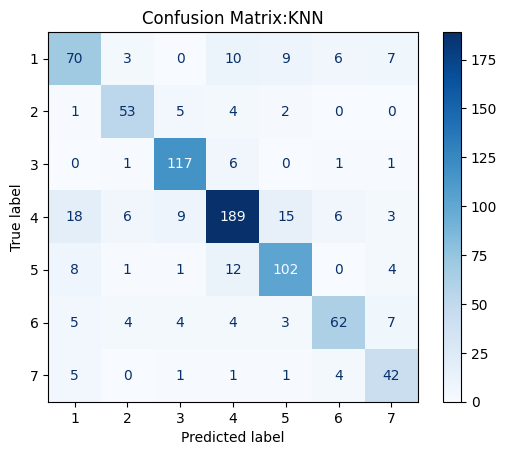

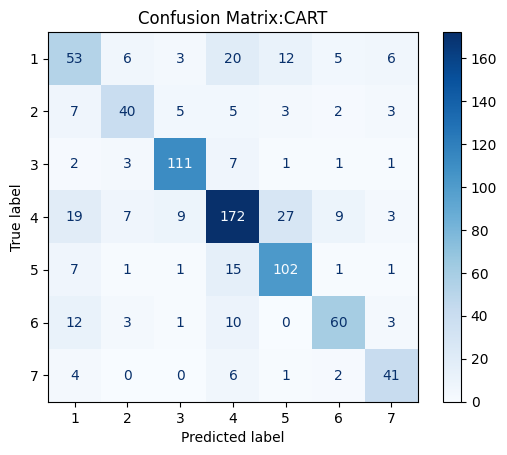

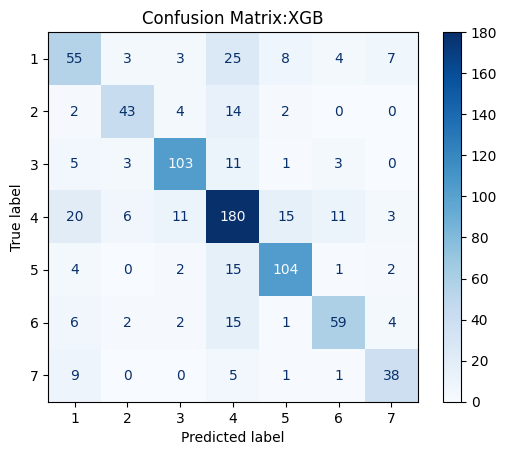

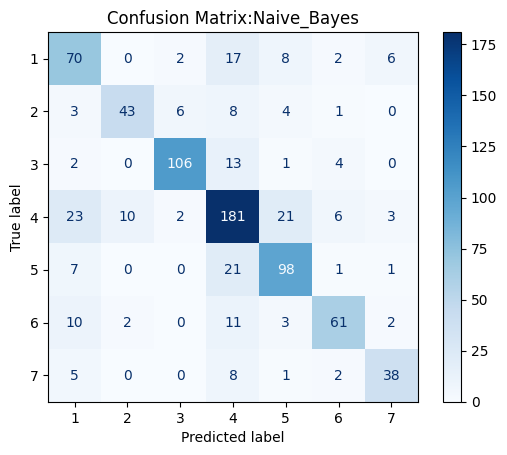

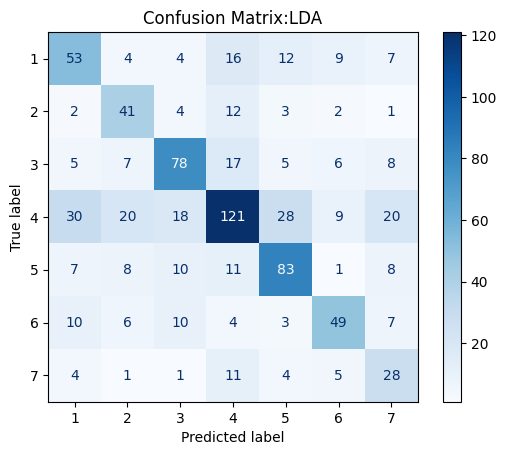

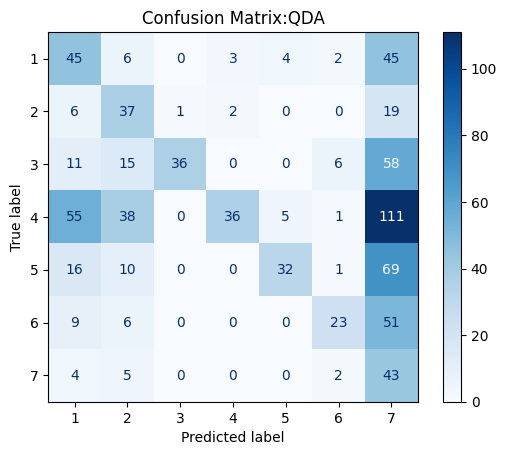

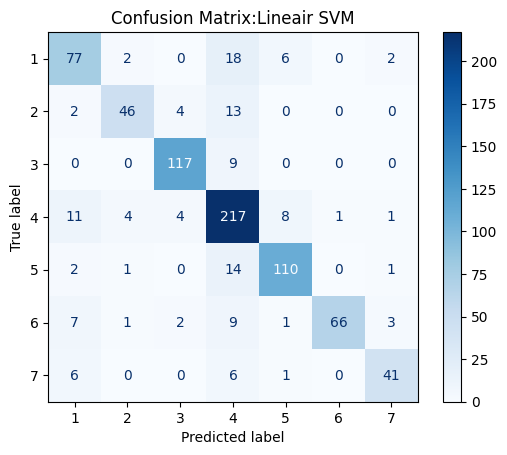

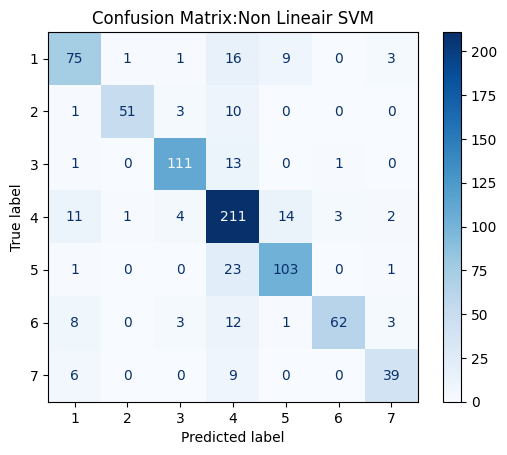

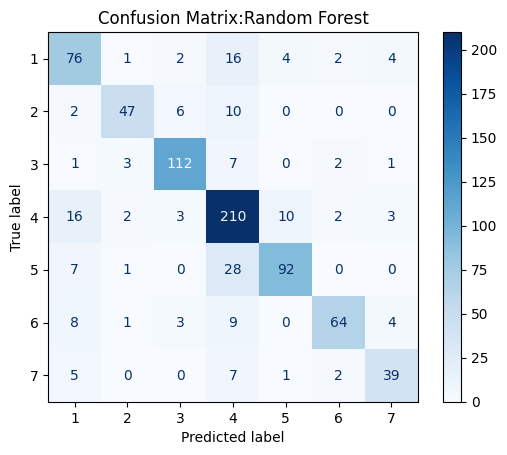

In [ ]:
MF3_df,MF3_Roc=apply_all_methods(X_train,Y_train,Y_test,MF3_methods)

**Tableau récapitulatif des résultats des modèles sur la matrice combinée F3**

In [ ]:
MF3_df

Acc       NMI  F1_score       AUC
Modeles                     -         -         -         -
Logistic Regression  0.822878  0.627966  0.811148  0.955576
KNN                  0.781058  0.552516  0.768932  0.870518
CART                 0.712177  0.454746  0.702324  0.827728
XGB                  0.715867  0.456104  0.710029  0.889207
Naive_Bayes          0.734317  0.491497   0.73427  0.841533
LDA                  0.557196  0.257168  0.546546  0.788516
QDA                  0.309963  0.182638  0.342646  0.641422
Lineair SVM          0.829028  0.638547  0.823336  0.958112
Non Lineair SVM      0.801968  0.600311  0.804965  0.961057
Random Forest        0.787208  0.567077  0.781713  0.942997

Après l'application de la fonction de combinaison F3 avec \(P=2\), nous avons constaté dans le tableau une amélioration des performances de certains algorithmes en ce qui concerne les scores tels que l'accuracy, le F1-score , NMI et l'AUC, par rapport aux résultats obtenus avec la fonction d'agrégation F2 (\(A@X\)). Cette amélioration est particulièrement notable pour les modèles KNN, Naive-bayes, LDA et QDA. Ces modèles ont affiché des taux d'accuracy de 78 %, 73 %, 55 %, 30 % respectivement, des scores NMI dépassant 55%, 49%, 25%, 18% respectivement, des F1-scores dépassant respectivement 76 %, 73 %, 54 %, 34 %, et des AUC dépassant 87 %, 84 %, 78 %, 64 %.

Il est à noter que la fonction F1 demeure la plus performante selon ces critères.

**Visualisation de la courbe ROC**

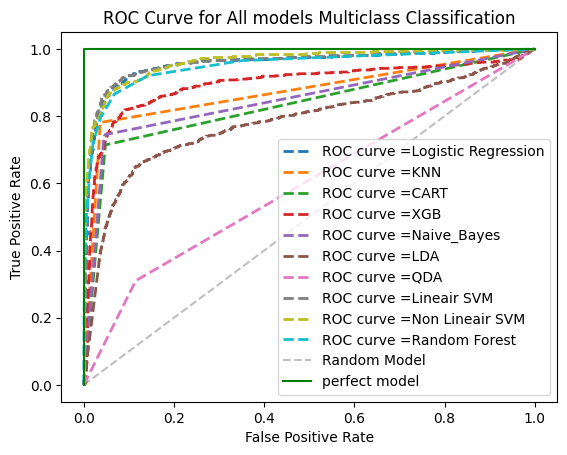

In [ ]:
Plot_all_ROC(MF3_Roc)

En examinant le graphique, nous constatons que les courbes ROC des modèles appliquées à la matrice combinée avec F3 (P=2) présentent des similitudes avec celles obtenues avec la matrice combinée F2 (\(A@X\)). Il est essentiel de noter qu'il y a une amélioration de l'AUC pour les modèles KNN et QDA, dépassant respectivement les seuils de 87 % et 64 %.

#Conclusion

En synthèse, l’exploitation simultanée de la matrice d’objets X et de la matrice d’adjacence A, conjointement à l’utilisation de fonctions d’agrégation, a fourni des informations précieuses qui ont notablement amélioré les performances des modèles de classification tels que KNN, Logistic Regression, CART, Random Forest, LDA, QDA, XGB, Linear et Non Linear SVM. Cette amélioration a été évaluée en fonction des scores tels que l’exactitude (Accuracy), l’indice de Rand ajusté (NMI), le F1-score, et
l’aire sous la courbe (AUC), comparativement à l’utilisation exclusive de la matrice X originale.

Afin de réaliser la combinaison des deux matrices, nous avons utilisé trois fonctions d’agrégation, F1, F2 et F3. Pour la fonction d’agrégation F1, nous l’avons tout d’abord appliquée aux deux matrices. Ensuite, nous l’avons appliquée en normalisant séparément la matrice X originale avec TF-IDF et en utilisant la normalisation euclidienne L2.

Ces trois méthodes de combinaison ont généré de bons résultats, avec des scores (Accuracy, NMI, F1-score, AUC) satisfaisants pour l'ensemble des modèles de classification étudiés, comparativement à une application exclusive sur la matrice \(X\), et selon les résultats obtenus, il est à souligner que la fonction \(F1\) demeure la plus performante.